<b> There are no significant ethical or legal concerns with the contents of this notebook. Data protection and discrimination are not a concern. All data sourced is freely available. </b>

# Importing Data & Cleaning

In [1]:
import pandas as pd, re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import glob
import os
import numpy as np
import math
import seaborn as sb
import geocoder
import requests
import time
import folium
from folium.plugins import HeatMap, HeatMapWithTime
from geopy import distance
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error

<b> Importing PSNI street crime data from 08-2015 to 05-2018 and displaying the first five rows </b>

In [2]:
src_dir ='data/PSNI_StreetCrime_1Year'
psni_crime_data = pd.DataFrame()
list_ = []
i = 0
for root, dirs, files in os.walk(src_dir):
    allFiles = glob.glob(root + "/*.csv")
    for file in allFiles:
        year_df = pd.read_csv(file,index_col=None, header=0)
        list_.append(year_df)
        psni_crime_data = pd.concat(list_)
psni_crime_data.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-7.378949,54.717334,On or near Dublin Street,NaN,NaN,Anti-social behaviour,NaN,NaN
1,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-5.891082,54.222501,On or near Bracken Avenue,NaN,NaN,Anti-social behaviour,NaN,NaN
2,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-5.667276,54.663573,On or near High Street,NaN,NaN,Anti-social behaviour,NaN,NaN
3,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-5.962330,54.587243,On or near Rodney Parade,NaN,NaN,Anti-social behaviour,NaN,NaN
4,NaN,2015-08,Police Service of Northern Ireland,Police Service of Northern Ireland,-5.894063,54.590423,On or near Brenda Street,NaN,NaN,Anti-social behaviour,NaN,NaN


<b> Let's look at the data frame from a high level and identify the data type and stored data in the columns  </b>

In [3]:
psni_crime_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445745 entries, 0 to 13728
Data columns (total 12 columns):
Crime ID                 274726 non-null object
Month                    445745 non-null object
Reported by              445745 non-null object
Falls within             445745 non-null object
Longitude                443370 non-null float64
Latitude                 443370 non-null float64
Location                 445745 non-null object
LSOA code                0 non-null float64
LSOA name                0 non-null float64
Crime type               445745 non-null object
Last outcome category    0 non-null float64
Context                  0 non-null float64
dtypes: float64(6), object(6)
memory usage: 44.2+ MB


<b> There are a number of columns that are redundant, containing all null values. 

*Last outcome category: "Missing outcome data. Neither the British Transport Police nor the Police Service of Northern Ireland provide the Home Office with outcome data. Although we are exploring the possibility of this with both forces, technical challenges mean that a solution remains some way off." - https://data.police.uk/about/
    

*LSOA code, name: "Lower Layer Super Output Areas are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales." - Not Northern Ireland, https://www.datadictionary.nhs.uk/data_dictionary/nhs_business_definitions/l/lower_layer_super_output_area_de.asp?shownav=1

*Context: 'Currently, for newly added CSVs, this is always empty.'

Let's drop them from the table.  </b>

In [4]:
psni_crime_data = psni_crime_data.drop(['LSOA code', 'LSOA name', 'Last outcome category', 'Context'], axis=1)

In [5]:
psni_crime_data.describe(include='all')

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,Crime type
count,274726,445745,445745,445745,443370.000000,443370.000000,445745,445745
unique,11728,34,1,1,NaN,NaN,14872,14
top,0039cf64d3190556005848fe28bf5e9efe71a59ac7a09c...,2015-10,Police Service of Northern Ireland,Police Service of Northern Ireland,NaN,NaN,On or near,Anti-social behaviour
freq,34,15444,445745,445745,NaN,NaN,61638,171019
mean,NaN,NaN,NaN,NaN,-6.268281,54.620995,NaN,NaN
std,NaN,NaN,NaN,NaN,0.527199,0.227856,NaN,NaN
min,NaN,NaN,NaN,NaN,-8.148313,54.026858,NaN,NaN
25%,NaN,NaN,NaN,NaN,-6.512727,54.511284,NaN,NaN
50%,NaN,NaN,NaN,NaN,-6.011100,54.597057,NaN,NaN
75%,NaN,NaN,NaN,NaN,-5.924801,54.697173,NaN,NaN


<b> Crime ID is not shared by all the rows. According to the official police API (https://data.police.uk/docs/method/crime-street/), this is used as an ID for the API and is not a police identifier.  Let's investigate this ID further and decide whether it is valuable to have in the table. </b>

In [6]:
num_unique_crime_ids = psni_crime_data['Crime ID'].nunique()
print(f"Number of unique crime ids: {num_unique_crime_ids}")

psni_crime_data_crimetype = psni_crime_data.groupby('Crime type')['Crime ID'].count()
psni_crime_data_crimetype

Number of unique crime ids: 11728


Crime type
Anti-social behaviour                0
Bicycle theft                     2141
Burglary                         20368
Criminal damage and arson        52336
Drugs                            16483
Other crime                       7472
Other theft                      37313
Possession of weapons             2701
Public order                      3334
Robbery                           1732
Shoplifting                      17389
Theft from the person             1253
Vehicle crime                    11743
Violence and sexual offences    100461
Name: Crime ID, dtype: int64

<b> Anti social behaviour does not have any Crime IDs associated with them. As Crime ID is not unique this makes me suspect there could be duplicates of the same crime in the table. I'm going to investigate this by finding rows with the same Crime ID, Month, Longitude, Latitude, Location and Crime Type </b>

In [7]:
grouped_psni_crime_data = psni_crime_data.fillna(-1).groupby(['Crime ID','Month', 'Longitude','Latitude', 'Location', 'Crime type']).size().reset_index(name='counts')

In [8]:
num_duplicate_rows = grouped_psni_crime_data[grouped_psni_crime_data.counts > 1].counts.sum()
percent_duplicate_rows = "{:.1%}".format(num_duplicate_rows/len(psni_crime_data))
print(f"{percent_duplicate_rows}")

16.3%


<b> 16.3% of rows could be potentially duplicate. I will drop Crime ID as it is not an effective unique identifier for the rows and has no use interacting with the Police API.</b>
<img src="psni response crime id.png">

In [9]:
psni_crime_data = psni_crime_data.drop(['Crime ID'], axis=1)

<b> 'Reported by' and 'Falls within' columns can be dropped as in all entries they are both set to 'Police Service of Northern Ireland'</b>

In [10]:
print(psni_crime_data['Reported by'].nunique())
print(psni_crime_data['Falls within'].nunique())
psni_crime_data = psni_crime_data.drop(['Reported by', 'Falls within'], axis=1)

1
1


<b> There is NaN float values in the longitude and latitude. Let's investigate this further. </b>

In [11]:
psni_crime_data[psni_crime_data['Longitude'].isnull() | psni_crime_data['Longitude'].isnull()].head()

,Month,Longitude,Latitude,Location,Crime type
225,2015-08,NaN,NaN,No Location,Anti-social behaviour
3812,2015-08,NaN,NaN,No Location,Anti-social behaviour
5713,2015-08,NaN,NaN,No Location,Bicycle theft
5732,2015-08,NaN,NaN,No Location,Bicycle theft
6223,2015-08,NaN,NaN,No Location,Burglary


<b> I'm going to verify that Location value is 'No Location' when Longitude and Latitude columns are null. </b>

In [12]:
psni_crime_data[(psni_crime_data['Location'] == 'No Location') & ~(psni_crime_data['Longitude'].isnull() & psni_crime_data['Longitude'].isnull())].head()

,Month,Longitude,Latitude,Location,Crime type


<b> Let's add a binary column that is 1 if the location associated and 0 if it does not not. This will make excluding these datasets more manageable when geographing the crimes. </b>

In [13]:
def has_location(row):
    if (math.isnan(row['Longitude']) or math.isnan(row['Latitude']) or row['Location'] == 'No Location'):
        return False
    else:
        return True

psni_crime_data['Has_Location'] = psni_crime_data.apply(lambda row: has_location (row),axis=1)

In [14]:
psni_crime_data.dtypes

Month            object
Longitude       float64
Latitude        float64
Location         object
Crime type       object
Has_Location       bool
dtype: object

<b> The month column data is presented in the format yyyy-mm. This can be converted to datetime split up into more columns to allow for more information to be derived. </b>

In [15]:
psni_crime_data['Date'] = pd.to_datetime(psni_crime_data['Month'], format='%Y-%m')
psni_crime_data = psni_crime_data.drop(['Month'], axis=1)

<b> The following add_datepart algorithm is from fastai (https://www.fast.ai/). </b>

In [16]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Quarter']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)
        

In [17]:
add_datepart(psni_crime_data, 'Date')

In [18]:
psni_crime_data.dtypes

Longitude       float64
Latitude        float64
Location         object
Crime type       object
Has_Location       bool
Year              int64
Month             int64
Week              int64
Quarter           int64
dtype: object

<b>Location has the streets listed with 'On or near' preceding them. This can be formatted to remove 'On Or Near' to get a cleaner street name for use in geocoding the crimes to find more location information.</b>

In [19]:
def format_street(row):
    formattedstreet = row['Location']
    formattedstreet = formattedstreet.replace('On or near', '')
    formattedstreet = formattedstreet.strip()
    return formattedstreet.lower()
    

psni_crime_data['Location'] = psni_crime_data.apply(lambda row: format_street(row), axis=1)

In [20]:
psni_crime_data[psni_crime_data['Location'] == 'dublin street'].head(5)

,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter
0,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3
3019,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3
6544,-7.378949,54.717334,dublin street,Criminal damage and arson,True,2015,8,31,3
2606,-7.380017,54.713413,dublin street,Anti-social behaviour,True,2015,9,36,3
877,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,10,40,4


<b> I'm going to categorise Location and Crime type as this will make the data splittable </b> 

In [21]:
psni_crime_data.dtypes
psni_crime_data['Crime type'] = psni_crime_data['Crime type'].astype('category')
psni_crime_data['Location'] = psni_crime_data['Location'].astype('category')

In [22]:
psni_crime_data.dtypes

Longitude        float64
Latitude         float64
Location        category
Crime type      category
Has_Location        bool
Year               int64
Month              int64
Week               int64
Quarter            int64
dtype: object

<b> I am now content the data has been cleaned. </b>

# Visualising crime trends

<b> I am going to create a chart showing the crimes per month and year to see if there is any general trend in crime year by year.</b>

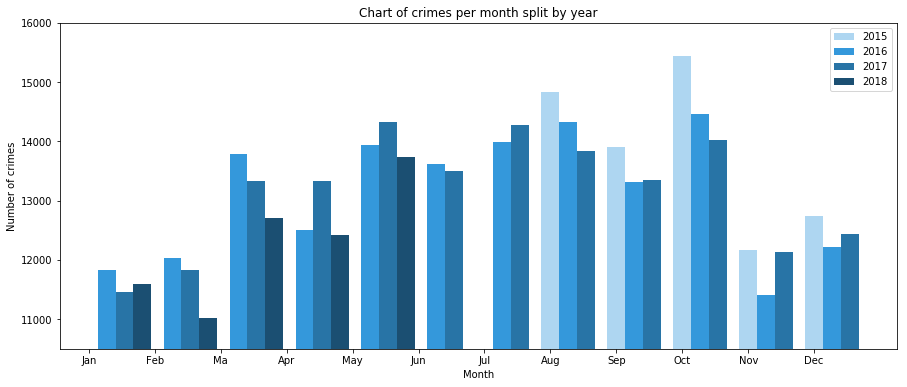

In [23]:
psni_crime_data_grouped_month_year = psni_crime_data.groupby(['Month', 'Year']).size().reset_index(name='counts')
width = 0.27

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

yvals2015 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2015].counts
xvals2015 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2015].Month
rects2015 = ax.bar(xvals2015, yvals2015, width, color='#AED6F1')

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].counts
xvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].Month
rects2016 = ax.bar(xvals2016+width, yvals2016, width, color='#3498DB')

yvals2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].counts
xvals2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].Month
rects2017 = ax.bar(xvals2017+width*2, yvals2017, width, color='#2874A6')

yvals2018 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2018].counts
xvals2018 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2018].Month
rects2018 = ax.bar(xvals2018+width*3, yvals2018, width, color='#1B4F72')

ax.set_ylabel('Number of crimes')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(1, 13, step=1.0))
ax.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
ax.legend([rects2015[0], rects2016[0], rects2017[0], rects2018[0]], ('2015', '2016', '2017', '2018'))

plt.title("Chart of crimes per month split by year")

plt.ylim(10500, 16000)

plt.show()

<b> Across the 4 years there seems to be a general decrease in total crimes in the winter months (January, February) and a peak in October. There is crime total drops every year for the months February, March, August and October. July (albeit with less data than the other months) shows a rise. </b>

<b> I am going to group the time specific columns to see if there is any general observations I can gather from the month, year and quarter of crime. The data ranges from 2015-08 to 2018-05 so I am going to choose 2016-01 to 2017-12 as the range to avoid months disproportionately provided more crime totals when visualising graphs. I am going to visualise the difference in month crime totals 2016 vs 2017.</b>

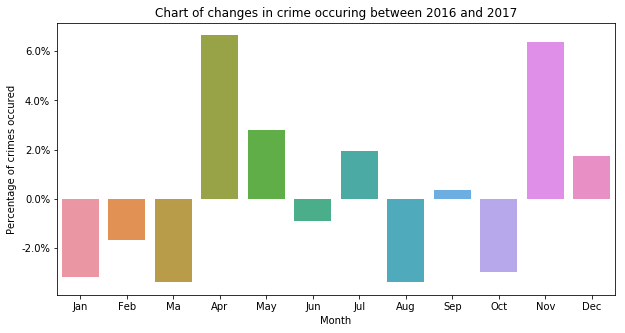

In [24]:
plt.figure(figsize=(10,5))
counts_per_month_2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].reset_index()
counts_per_month_2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].reset_index()


dictMonth = {}
for index, row in counts_per_month_2017.iterrows():
    difference = (row['counts'] - counts_per_month_2016.iloc[index].counts)
    difference_percent = difference/(counts_per_month_2016.iloc[index].counts)*100
    dictMonth[str(index+1)] = difference_percent
    
difference_2016_2017 = pd.DataFrame.from_dict(dictMonth, orient='index')
difference_2016_2017.index = difference_2016_2017.index.astype(float)

ax = sb.barplot(difference_2016_2017.index, difference_2016_2017[0])
ax.set_ylabel('Percentage of crimes occured')
ax.set_xlabel('Month')
ax.set(xticks=(np.arange(0, 12, step=1.0)))
ax.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Chart of changes in crime occuring between 2016 and 2017")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

<b> There is a considerable increase in crime in 2017 in the months April and November from 2016. </b>

<b> I'm going to look at a month and quarter level to see if there's any differences in times of the year and the number of crimes occurring in the period 2016-2017. </b>

In [25]:
psni_crime_data = psni_crime_data.reset_index()
psni_crime_data_ranged = psni_crime_data.drop(psni_crime_data[(psni_crime_data['Year'] == 2015) \
                                                              | ((psni_crime_data['Year'] == 2018))].index)
psni_crime_data_grouped_month = psni_crime_data_ranged.groupby('Month').size().reset_index(name='counts')
psni_crime_data_grouped_year = psni_crime_data_ranged.groupby('Year').size().reset_index(name='counts')
psni_crime_data_grouped_quarter = psni_crime_data_ranged.groupby('Quarter').size().reset_index(name='counts')

psni_crime_data_grouped_quarter_year = psni_crime_data.groupby(['Quarter', 'Year']).size().reset_index(name='counts')

counts_per_quarter_2017 = psni_crime_data_grouped_quarter_year[psni_crime_data_grouped_quarter_year.Year == 2017].reset_index()
counts_per_quarter_2016 = psni_crime_data_grouped_quarter_year[psni_crime_data_grouped_quarter_year.Year == 2016].reset_index()

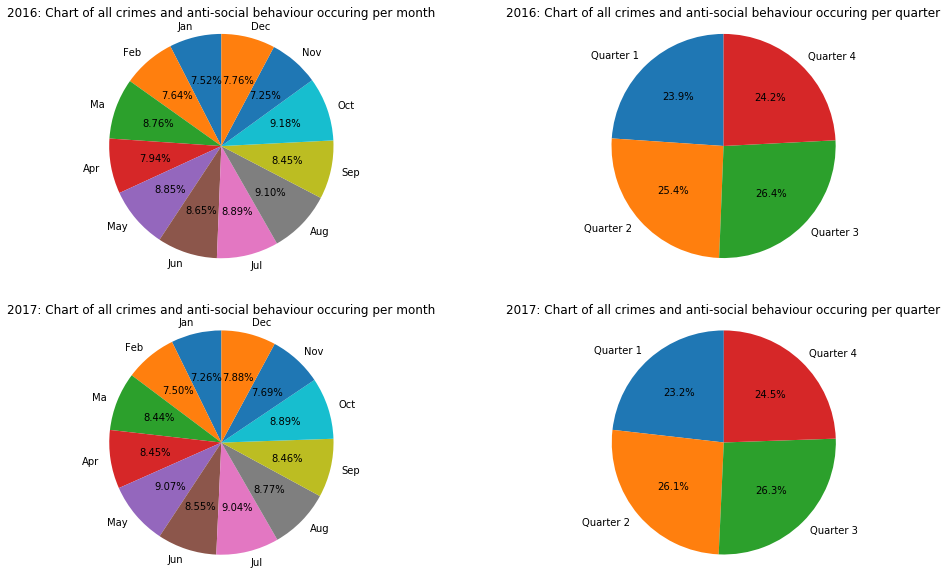

In [26]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.pie(counts_per_month_2016['counts'], labels = ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), \
        autopct='%1.2f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("2016: Chart of all crimes and anti-social behaviour occuring per month")

plt.subplot(2,2, 2)
plt.title("2016: Chart of all crimes and anti-social behaviour occuring per quarter")
plt.pie(counts_per_quarter_2016['counts'], labels = ('Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4'), autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.pie(counts_per_month_2017['counts'], labels = ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), \
        autopct='%1.2f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("2017: Chart of all crimes and anti-social behaviour occuring per month")

plt.subplot(2,2, 4)
plt.title("2017: Chart of all crimes and anti-social behaviour occuring per quarter")
plt.pie(counts_per_quarter_2017['counts'], labels = ('Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4'), autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.5)

<b> 2016: Most crimes in October and Quarter 3. Least crimes in month November and Quarter 1.
    2017: Most crimes in May and Quarter 3. Least crimes in January and Quarter 1. Let's take a look at comparing 2016 and 2017 and see if there is a trend in those periods.</b>

Text(0.5,1,'Chart of all crimes and anti-social behaviour occuring per month: 2016 versus 2017')

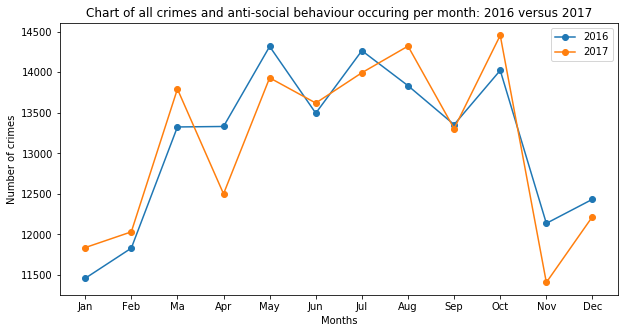

In [27]:
plt.figure(figsize=(10,5))

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].counts
xvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].Month
yvals2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].counts
xvals2017 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].Month
plt.plot(xvals2017, yvals2017, marker = 'o')
plt.plot(xvals2016, yvals2016, marker = 'o')
plt.xticks(np.arange(1, 13, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.legend([2016, 2017])
plt.title("Chart of all crimes and anti-social behaviour occuring per month: 2016 versus 2017")

<b> There appears to be a rise in crimes in the spring and summer months and a fall in the winter. I'm going to use numpy polyfit to estimate a polynomial curve to better visualise the yearly trend of number of crime. I'm going to include data from 2015 and 2018 as this is not directly comparing totals for each month and will provide more samples for the regressive curve. </b>



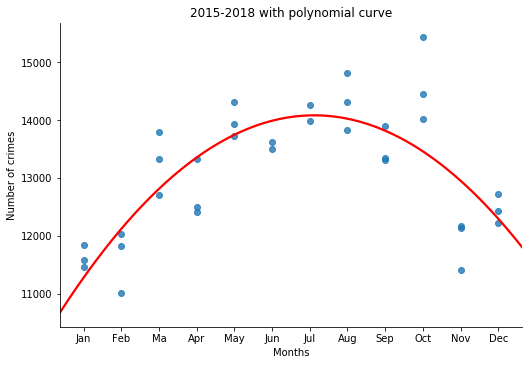

In [28]:
sb.lmplot('Month','counts',data=psni_crime_data_grouped_month_year[(psni_crime_data_grouped_month_year.Year >= 2015)], order=2, ci=None, height=5, aspect=1.5, line_kws={'color': 'red'})
plt.xticks(np.arange(1, 13, step=1.0),('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.title("2015-2018 with polynomial curve")
plt.show()

<b> There is a higher occurence of crimes in summer months (June, July August) than in Winter Months (December, January, February). I am going to investigate the type of crimes being committed these months to see if there's a type of crime more or less prevelant in particular months. There could be crime types that are more prevelant in the summer causing the rise in the total of crime </b>

<b> I'm going to take a look at first crime types in 2016 vs 2017 to see if there is any notable increases or decreases. </b>

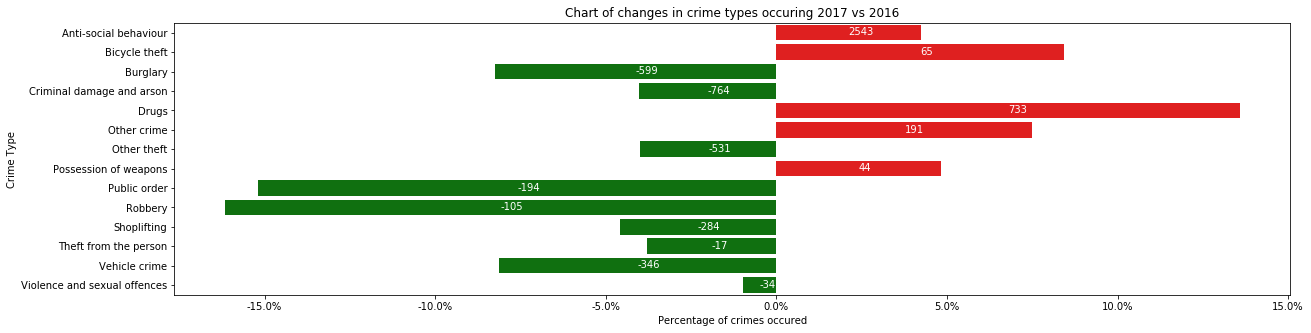

In [29]:
psni_crime_data_grouped_crime_type = psni_crime_data_ranged.groupby(['Year', 'Crime type']).size().reset_index(name='counts')
psni_crime_data_grouped_crime_type
plt.figure(figsize=(20,5))
counts_per_month_2017 = psni_crime_data_grouped_crime_type[psni_crime_data_grouped_crime_type.Year == 2017].reset_index()
counts_per_month_2016 = psni_crime_data_grouped_crime_type[psni_crime_data_grouped_crime_type.Year == 2016].reset_index()

dictMonth = {}
dictDiffRaw = []
for index, row in counts_per_month_2017.iterrows():
     difference = (row['counts'] - counts_per_month_2016.iloc[index].counts)
     difference_percent = difference/(counts_per_month_2016.iloc[index].counts)*100
     dictMonth[row['Crime type']] = difference_percent
     dictDiffRaw.append(difference)
   
difference_2016_2017 = pd.DataFrame.from_dict(dictMonth, orient='index')
difference_2016_2017.index = difference_2016_2017.index.astype(str)

difference_2016_2017.head()
ax = sb.barplot(difference_2016_2017[0], difference_2016_2017.index, data=difference_2016_2017, palette=difference_2016_2017[0].apply(lambda x: 'r' if x>0 else 'g'))
ax.set_xlabel('Percentage of crimes occured')
ax.set_ylabel('Crime Type')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Chart of changes in crime types occuring 2017 vs 2016")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

total = float(len(difference_2016_2017))

i = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    ax.text(p.get_x()+width/2,
             p.get_y()+height/1.5,
             dictDiffRaw[i],
           color='white')
    i += 1

<b> ASB sees an increase from 2016 to 2017. Drug crimes sees the largest % increase from 2016 to 2017. Robbery sees the largest  % decrease from 2016 to 2017. </b>

<b> I've visualised crime type as yearly comparison, now let's look at it by month. </b>

In [30]:
psni_crime_data_grouped_crime_type = psni_crime_data_ranged.groupby(['Month', 'Crime type']).size().reset_index(name='counts')
psni_crime_data_grouped_crime_type.head()

,Month,Crime type,counts
0,1,Anti-social behaviour,8366
1,1,Bicycle theft,87
2,1,Burglary,1228
3,1,Criminal damage and arson,2781
4,1,Drugs,890


In [31]:
psni_crime_data_grouped_crime_type_pivot = psni_crime_data_grouped_crime_type.pivot('Month', 'Crime type', 'counts')
psni_crime_data_grouped_crime_type_pivot.head()

Crime type,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
Month,,,,,,,,,,,,,,
1,8366,87,1228,2781,890,392,2049,137,170,100,812,70,722,5491
2,8461,92,1263,2748,941,512,2193,126,215,98,1042,84,670,5416
3,10199,94,1243,3325,1012,525,2136,172,235,97,980,64,702,6334
4,10035,125,1094,3173,971,399,2144,164,191,103,1027,82,701,5622
5,11419,169,1137,3261,880,494,2275,178,217,84,1031,75,619,6410


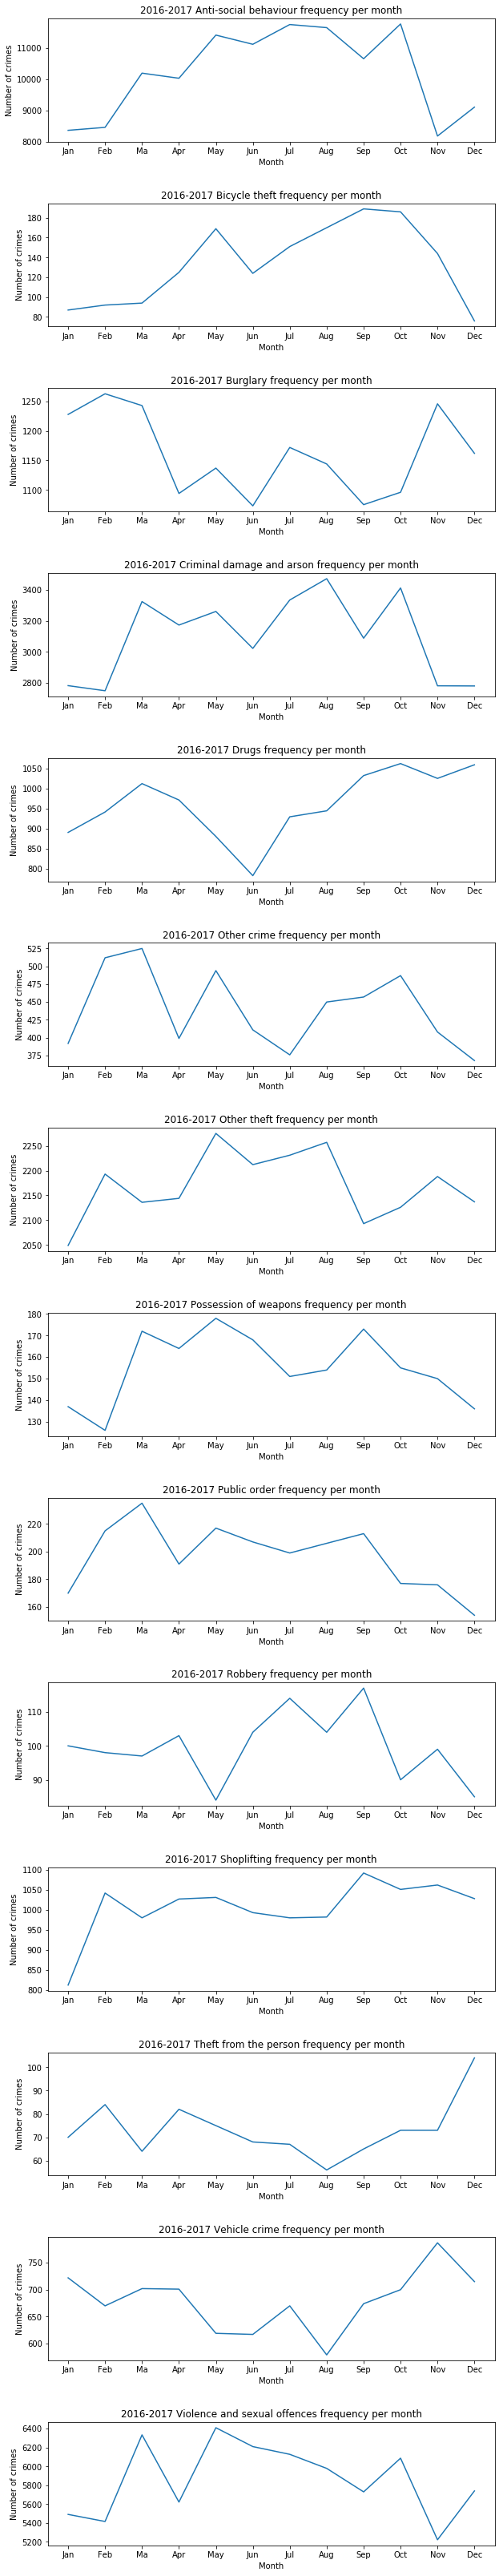

In [32]:
psni_crime_data_grouped_crime_type_pivot_hm = psni_crime_data_grouped_crime_type.pivot('Month', 'Crime type', 'counts')
plt.figure(figsize=(10,58))
i=1
for column in psni_crime_data_grouped_crime_type_pivot_hm.columns:
    if (column != 'Crime type'):
        ax = plt.subplot(len(psni_crime_data_grouped_crime_type_pivot_hm.columns),1,i)
        plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
        plt.title(f'2016-2017 {column} frequency per month')
        plt.xlabel('Month')
        sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm[column])
        plt.ylabel('Number of crimes')
        i += 1
plt.subplots_adjust(hspace=0.5)


<b> Anti social behaviour: peaks in October, is prevelant in July and August and is least prevelant in November. There is a big drop between October and November.

Bicycle theft: Rise in June to peak in September, falls after to December.

Drugs: peak in October, least prevelant in June.

Theft from the person frequency per month: Rise from August to peak in December.

From identifying a number of crimes above, I can observe different crime types have different prevelances across the year. I'm going to visualise this using a heatmap to see if I can gather any additional observations from a more direct comparison of totals across months. </b>

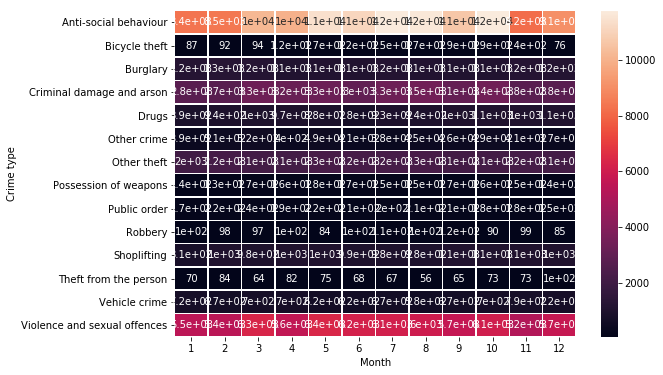

In [33]:
psni_crime_data_grouped_crime_type_pivot_hm_transposed = psni_crime_data_grouped_crime_type_pivot_hm.transpose()
f, ax = plt.subplots(figsize=(9, 6))
sb.heatmap(psni_crime_data_grouped_crime_type_pivot_hm_transposed, annot=True, linewidths=.5, ax=ax)

<b> This heat map is not very informative, with high counts of particular crimes and anti social behaviour not providing an insight into minor crimes frequency per month. Let's normalize the data frame using standard normal distribution to better see the distribution of each crime type over a year. </b>

In [34]:
psni_crime_data_grouped_crime_type_pivot_hm_normalised = psni_crime_data_grouped_crime_type.pivot('Month', 'Crime type', 'counts')
psni_crime_data_grouped_crime_type_pivot_hm_normalised =(psni_crime_data_grouped_crime_type_pivot_hm_normalised-psni_crime_data_grouped_crime_type_pivot_hm_normalised.mean(axis=0))/psni_crime_data_grouped_crime_type_pivot_hm_normalised.std(axis=0)
psni_crime_data_grouped_crime_type_pivot_hm_normalised_transpose = psni_crime_data_grouped_crime_type_pivot_hm_normalised.transpose()
psni_crime_data_grouped_crime_type_pivot_hm_normalised_transpose.head(5)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Crime type,,,,,,,,,,,,
Anti-social behaviour,-1.340441,-1.272085,-0.021526,-0.139531,0.856311,0.644047,1.099516,1.028281,0.310901,1.112467,-1.472117,-0.805824
Bicycle theft,-1.167723,-1.043276,-0.993498,-0.221930,0.873199,-0.246819,0.425192,0.898089,1.370985,1.296317,0.250967,-1.441505
Burglary,0.957883,1.458893,1.172602,-0.960269,-0.344743,-1.260875,0.156267,-0.244541,-1.232246,-0.931640,1.215546,0.013122
Criminal damage and arson,-1.167728,-1.289226,0.835144,0.275518,0.599512,-0.280427,0.871961,1.380043,-0.037431,1.159138,-1.171410,-1.175092
Drugs,-0.843649,-0.234070,0.614559,0.124505,-0.963174,-2.134522,-0.377501,-0.198213,0.853610,1.212185,0.769942,1.176328


Text(0.5,1,'Standard Normal Distribution: Types of Crime Prevelance Across Years 2016 & 2017')

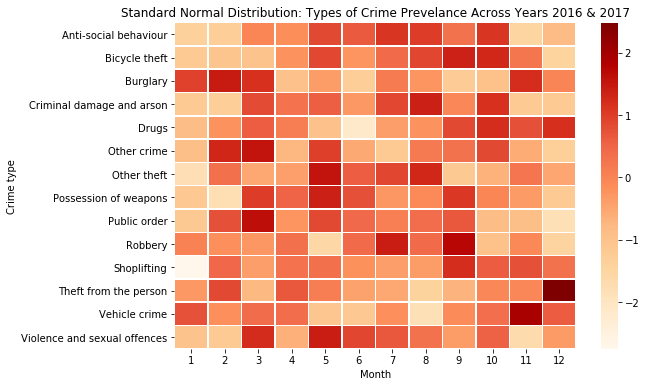

In [35]:
f, ax = plt.subplots(figsize=(9, 6))
sb.heatmap(psni_crime_data_grouped_crime_type_pivot_hm_normalised_transpose, linewidths=.5, ax=ax, cmap="OrRd")
plt.title('Standard Normal Distribution: Types of Crime Prevelance Across Years 2016 & 2017')

<b>
Burglary prevelant in January, February and March. 

Bicycle theft prevelant in September and October. 

Drugs prevelant October, November and December. 

Vehicle crime prevelant in November.

Theft from the person prevelant in December.


Some crimes have blocks in which they are prevelant and less prevelant, there is not an even distribution across the year. Anti Social Behaviour has a 'cooling off' period between November and February in which the monthly total is lower than the rest of the year. As this is mainly an analysis on anti social behaviour let's compare which crimes are most similar to the distribution of anti social behaviour across the year.

</b>

# Comparing prevelance of different crimes types with anti social behaviour

<b> We can use correlation to find crimes that follow the same to month trend with Anti social behaviour

In [36]:
psni_crime_data_grouped_crime_type_pivot_hm_normalised.corr()

Crime type,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
Crime type,,,,,,,,,,,,,,
Anti-social behaviour,1.000000,0.689546,-0.676137,0.891696,-0.171621,0.177150,0.454125,0.611439,0.374159,0.164878,0.190411,-0.472994,-0.687867,0.817012
Bicycle theft,0.689546,1.000000,-0.576943,0.624710,0.107058,0.201760,0.311338,0.540316,0.205160,0.276749,0.463775,-0.527865,-0.333636,0.289333
Burglary,-0.676137,-0.576943,1.000000,-0.437462,0.112229,0.164234,-0.054854,-0.562442,0.008333,-0.186391,-0.326067,0.096519,0.449031,-0.394611
Criminal damage and arson,0.891696,0.624710,-0.437462,1.000000,0.031076,0.327298,0.362878,0.597933,0.437968,0.130549,0.108549,-0.575198,-0.527493,0.740045
Drugs,-0.171621,0.107058,0.112229,0.031076,1.000000,0.107786,-0.406453,-0.141277,-0.307126,-0.146316,0.458527,0.292001,0.561364,-0.282991
Other crime,0.177150,0.201760,0.164234,0.327298,0.107786,1.000000,0.134346,0.282873,0.700746,-0.234718,0.285462,-0.282556,-0.259062,0.332807
Other theft,0.454125,0.311338,-0.054854,0.362878,-0.406453,0.134346,1.000000,0.203145,0.381119,-0.096394,0.279448,-0.170646,-0.597920,0.407261
Possession of weapons,0.611439,0.540316,-0.562442,0.597933,-0.141277,0.282873,0.203145,1.000000,0.552583,0.140516,0.280023,-0.472374,-0.328631,0.644527
Public order,0.374159,0.205160,0.008333,0.437968,-0.307126,0.700746,0.381119,0.552583,1.000000,0.288855,0.176711,-0.550579,-0.532474,0.499928


<b> Criminal damage and arson and violence and sexual offences frequencies are most positively correlated to anti social behaviour frequency. Vehicle crime and burglary frequencies are the most negatively correlated to anti social behaviour frequency. I'm going to draw the graphs of each to compare their monthly prevelance with anti social behaviour. </b>

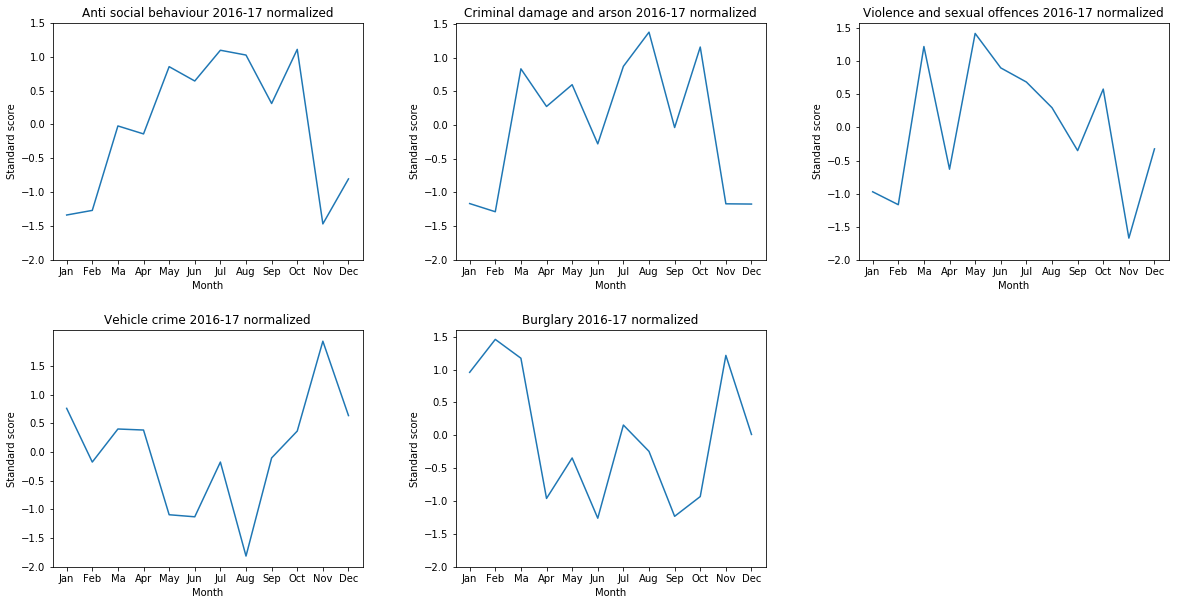

In [37]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title('Anti social behaviour 2016-17 normalized')
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Anti-social behaviour'])
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(-2, 2, step=0.5))
plt.ylabel('Standard score')
plt.xlabel('Month')

plt.subplot(2, 3, 2)
plt.title('Criminal damage and arson 2016-17 normalized')
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Criminal damage and arson'])
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(-2, 2, step=0.5))
plt.ylabel('Standard score')
plt.xlabel('Month')

plt.subplot(2, 3, 3)
plt.title('Violence and sexual offences 2016-17 normalized')
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Violence and sexual offences'])
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(-2, 2, step=0.5))
plt.ylabel('Standard score')
plt.xlabel('Month')


plt.subplot(2, 3, 4)
plt.title('Vehicle crime 2016-17 normalized')
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Vehicle crime'])
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(-2, 2, step=0.5))
plt.ylabel('Standard score')
plt.xlabel('Month')


plt.subplot(2, 3, 5)
plt.title('Burglary 2016-17 normalized')
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Burglary'])
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(-2, 2, step=0.5))
plt.ylabel('Standard score')
plt.xlabel('Month')

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.3)

<b> Positive correlation crimes: </b>

Criminal damage and arson: February to March considerable rise.

Violence and sexual offences: peak in May and fell in September. September to October rise. There's a noticeable rise from February to March and then a fall in April.

ASB and Criminal Damage and Arson are least prevelant in Winter. Violence and sexual offences do see a rise in December, but a sharp fall after in January in February.

<b> Negative correlation crimes: </b>

Vehicle crime: Fall January to August, least prevelant in August. Considerable rise from August to peak in November, falls after December.

Burglary: Peak in February fall to least prevelant in June, rise in July. Rise September to November.


I'm going to compare the most correlated and least correlated by overlapping the ASB frequency. 

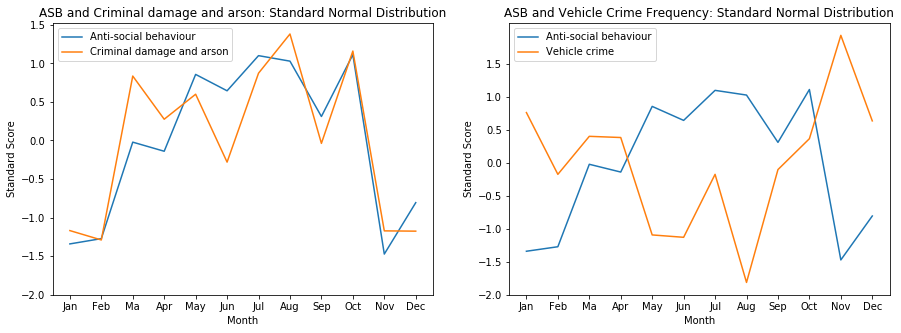

In [38]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Anti-social behaviour'])
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Criminal damage and arson'])
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(-2, 2, step=0.5))
plt.ylabel('Standard Score')
plt.xlabel('Month')
plt.title('ASB and Criminal damage and arson: Standard Normal Distribution')
plt.legend(['Anti-social behaviour', 'Criminal damage and arson'])


plt.subplot(1, 2, 2)
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Anti-social behaviour'])
sb.lineplot(np.arange(0, 12, step=1.0), psni_crime_data_grouped_crime_type_pivot_hm_normalised['Vehicle crime'])
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(-2, 2, step=0.5))
plt.ylabel('Standard Score')
plt.xlabel('Month')
plt.title('ASB and Vehicle Crime Frequency: Standard Normal Distribution')
plt.legend(['Anti-social behaviour', 'Vehicle crime'])

<b> The frequency of ASB and criminal damage and arson are visually similar in their frequency. ASB and Vehicle Crime do have an opposite trend in the months April-June. There is a rise from september to November while ASB has a decrease in that period. </b> 

# Seasonal Changes Investigation

<b> I have found that some types of crimes are more prevelant in times of the year. Speculating, a crime such as vehicle crime could be because of shorter days in the winter months and therefore more cover of darkness to commit the crime. The rise of crimes such as ASB could be because of more outdoor activity in the summer, with parties leading to street drinking. To investigate this further, I am going load in meteorological data from the Met Office ( https://www.metoffice.gov.uk/climate/uk/summaries/datasets). I am going to use average sunshine per month and compare it with the number of crimes. 'Period during which direct solar irradiance exceeds a threshold value of 120 W/m²' is the hour value in the table.
</b>

In [39]:
monthly_sunshine = pd.read_csv('data/MetOffice/Northern_Ireland_Sunshine.csv')
monthly_sunshine_4_years = monthly_sunshine[(monthly_sunshine.Year >= 2015)]
monthly_sunshine_4_years.head()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,WIN,SPR,SUM,AUT,ANN
86,2015,58.7,63.3,133.9,206.9,151.0,178.0,113.1,134.4,130.4,100.5,37.8,30.5,166,491.9,425.4,268.7,1338.5
87,2016,34.3,71.6,113.7,149.8,218.1,130.4,108.7,128.8,94.8,89.2,76.0,39.1,136.4,481.6,367.9,260.0,1254.5
88,2017,46.9,46.2,119.2,103.9,253.5,115.5,168.6,125.8,107.3,54.1,58.8,33.3,132.2,476.6,409.9,220.1,1233.1
89,2018,46.3,91.6,90.4,131.0,224.7,238.1,173.4,105.0,98.6,NaN,NaN,NaN,171.3,446.1,516.5,NaN,NaN


<b> Let's remove the season columns as this will be an analysis of frequency per month vs sunshine </b>

In [40]:
monthly_sunshine_4_years = monthly_sunshine_4_years.drop(['WIN', 'SPR', 'SUM', 'AUT', 'ANN'],  axis=1)

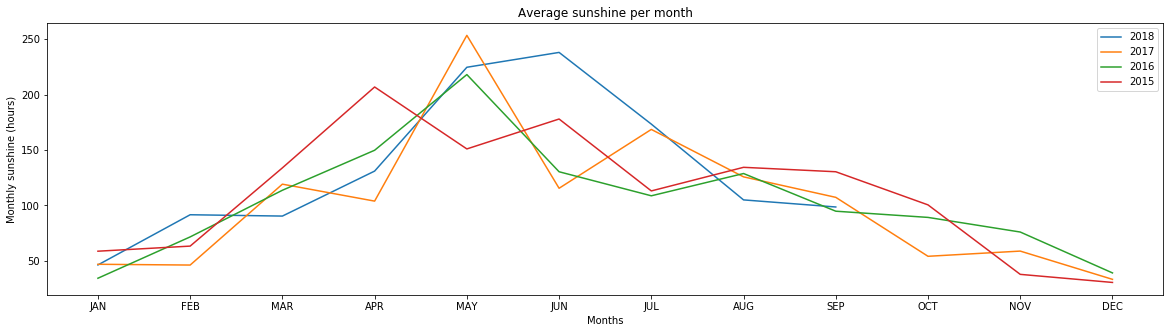

In [41]:
plt.figure(figsize=(20,5))
plt.plot(monthly_sunshine_4_years.drop('Year', axis=1).columns.tolist(), monthly_sunshine_4_years[monthly_sunshine_4_years['Year'] == 2018].drop('Year', axis=1).values.flatten().tolist())
plt.plot(monthly_sunshine_4_years.drop('Year', axis=1).columns.tolist(), monthly_sunshine_4_years[monthly_sunshine_4_years['Year'] == 2017].drop('Year', axis=1).values.flatten().tolist())
plt.plot(monthly_sunshine_4_years.drop('Year', axis=1).columns.tolist(), monthly_sunshine_4_years[monthly_sunshine_4_years['Year'] == 2016].drop('Year', axis=1).values.flatten().tolist())
plt.plot(monthly_sunshine_4_years.drop('Year', axis=1).columns.tolist(), monthly_sunshine_4_years[monthly_sunshine_4_years['Year'] == 2015].drop('Year', axis=1).values.flatten().tolist())
plt.xlabel('Months')
plt.ylabel('Monthly sunshine (hours)')
plt.title("Average sunshine per month")
plt.legend(['2018', '2017', '2016', '2015'])

<b> The spring and summer months have the most sunshine, while the autumn and winter have the least. This will provide a way to see if there is an influence of seasonal changes. I'm going to plot 2016 vs 2017 sunshine and crime frequency to see if there is any trend. </b> 

Text(0.5,1,'Average sunshine per month vs Number of crimes per month in 2017')

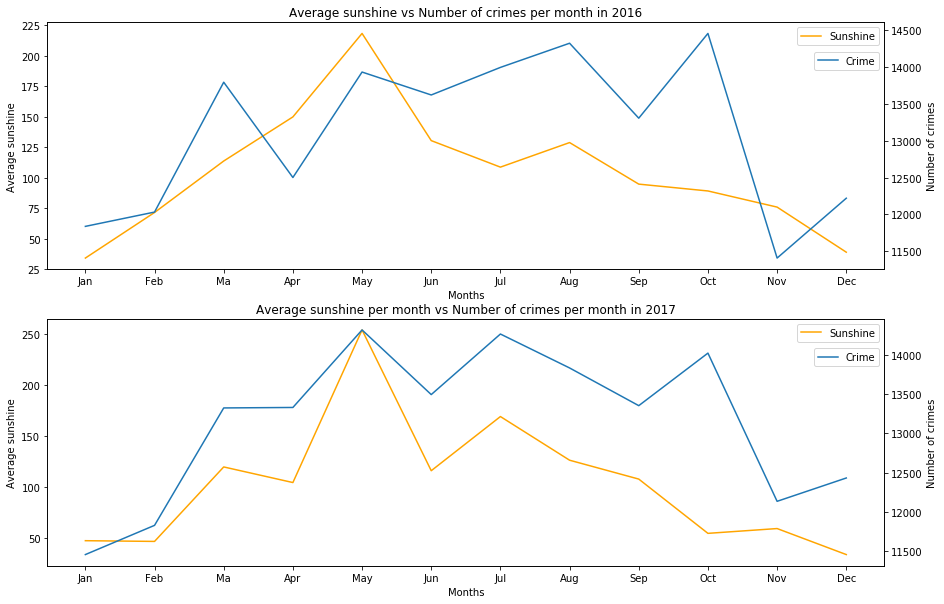

In [42]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
ax = sb.lineplot(np.arange(0, 12, step=1.0), monthly_sunshine_4_years[monthly_sunshine_4_years['Year'] == 2016].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)
ax.set_xlabel('Months')
ax.set_ylabel('Average sunshine')
ax2.set_ylabel('Number of crimes')

plt.title("Average sunshine vs Number of crimes per month in 2016")
ax.legend(['Sunshine'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.subplot(2,1,2)
ax = sb.lineplot(np.arange(0, 12, step=1.0), monthly_sunshine_4_years[monthly_sunshine_4_years['Year'] == 2017].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)

ax.set_xlabel('Months')
ax.set_ylabel('Average sunshine')
ax2.set_ylabel('Number of crimes')

ax.legend(['Sunshine'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.title("Average sunshine per month vs Number of crimes per month in 2017")

<b> 2016: The rise in sunshine in May appear to rise together with crime. The rise of sunshine in August and fall in September also occurs to the crime totals. However, the rise in crime in October is a fall in sunshine.

2017: The rise in sunshine in February to March rises together with crime. The peak of crimes and sunshine is May. The period from July to September sees a fall in both crime and sunshine.

Let's get a statistical figure for the correlation between monthly sunshine and monthly crime for 2015-2018</b>

In [43]:
#corr_sunshine_month_2016_2017 = monthly_sunshine_2016_2017.merge(psni_crime_data_grouped_month_year)

corr_sunshine_month_4_years = pd.DataFrame(columns=['counts', 'sunshine'])
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
crimes_month_year_4_years = psni_crime_data_grouped_month_year[(psni_crime_data_grouped_month_year['Year'] >= 2015)].reset_index()
for index,row in crimes_month_year_4_years.iterrows():
    counts = row['counts']
    month = months[row['Month']-1]
    sunshine = monthly_sunshine_4_years[monthly_sunshine_4_years['Year'] == row['Year']].iloc[0][month]
    corr_sunshine_month_4_years = corr_sunshine_month_4_years.append({'counts': counts, 'sunshine': sunshine}, ignore_index=True)

corr_sunshine_month_4_years.head()

,counts,sunshine
0,11837.0,34.3
1,11458.0,46.9
2,11585.0,46.3
3,12031.0,71.6
4,11830.0,46.2


In [44]:
corr_sunshine_month_4_years.corr()

,counts,sunshine
counts,1.000000,0.568879
sunshine,0.568879,1.000000


<b> There is a moderate positive linear relationship between average monthly sunshine and the number of crimes per month. I'm going to take a look at another meteorological reading to see if there is stronger correlation. Some crimes could be caused by people participating in more outdoor activities whenever there is hot weather. Let's load in the mean temperature for each month, once again from the met office. The values are in celsius and are the temperature across the month, not the mean average high temperature.</b>

In [45]:
mean_monthly_temp = pd.read_csv('data/MetOffice/Northern_Ireland_Mean_Temp.csv')
mean_temp_4_years = mean_monthly_temp[(mean_monthly_temp.Year >= 2015)]
mean_temp_4_years.head()

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,WIN,SPR,SUM,AUT,ANN
105,2015,3.7,3.9,5.6,7.7,9.1,12.3,13.3,13.6,11.8,9.8,7.9,6.9,4.05,7.46,13.09,9.85,8.83
106,2016,5.0,4.0,6.0,6.3,11.2,14.2,14.6,15.0,13.6,10.0,5.1,6.4,5.35,7.87,14.61,9.57,9.32
107,2017,5.2,5.3,7.2,8.2,12.1,13.8,14.4,13.9,11.9,10.8,5.8,4.7,5.64,9.17,14.05,9.53,9.47
108,2018,3.9,2.9,3.9,7.9,11.8,14.9,15.8,14.4,11.5,9.2,NaN,NaN,3.88,7.89,15.02,NaN,NaN


In [46]:
mean_temp_4_years = mean_temp_4_years.drop(['WIN', 'SPR', 'SUM', 'AUT', 'ANN'],  axis=1)

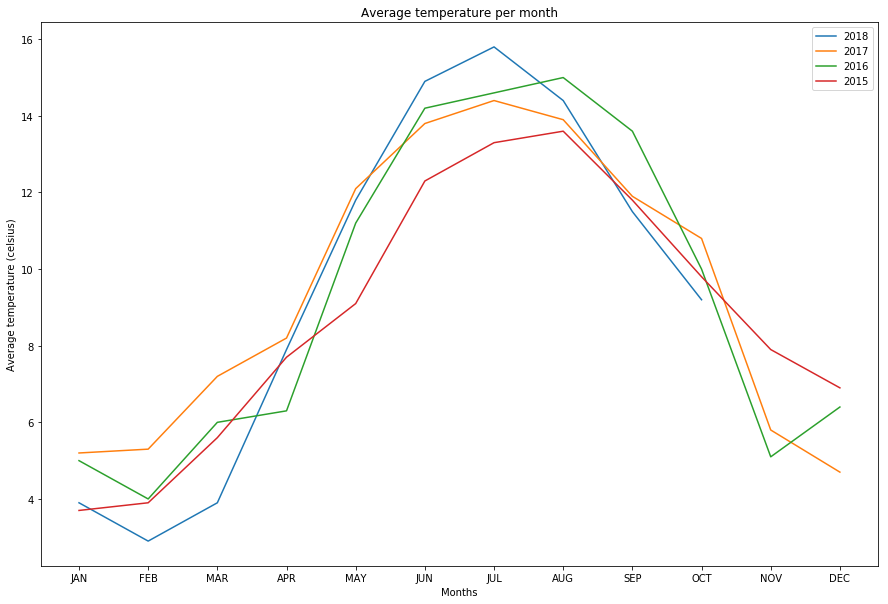

In [130]:
plt.figure(figsize=(15,10))
plt.plot(mean_temp_4_years.drop('Year', axis=1).columns.tolist(), mean_temp_4_years[mean_temp_4_years['Year'] == 2018].drop('Year', axis=1).values.flatten().tolist())
plt.plot(mean_temp_4_years.drop('Year', axis=1).columns.tolist(), mean_temp_4_years[mean_temp_4_years['Year'] == 2017].drop('Year', axis=1).values.flatten().tolist())
plt.plot(mean_temp_4_years.drop('Year', axis=1).columns.tolist(), mean_temp_4_years[mean_temp_4_years['Year'] == 2016].drop('Year', axis=1).values.flatten().tolist())
plt.plot(mean_temp_4_years.drop('Year', axis=1).columns.tolist(), mean_temp_4_years[mean_temp_4_years['Year'] == 2015].drop('Year', axis=1).values.flatten().tolist())
plt.xlabel('Months')
plt.ylabel('Average temperature (celsius)')
plt.title("Average temperature per month")
plt.legend(['2018', '2017', '2016', '2015'])

<b> The summer months have the highest temperature celsius, while the spring and winter have the lowest temperature celsius. Like with sunshine, let's plot the frequency of crime in 2016 and 2017 months with the monthly temperature. </b>

Text(0.5,1,'Average temperature per month vs Number of crimes per month in 2017')

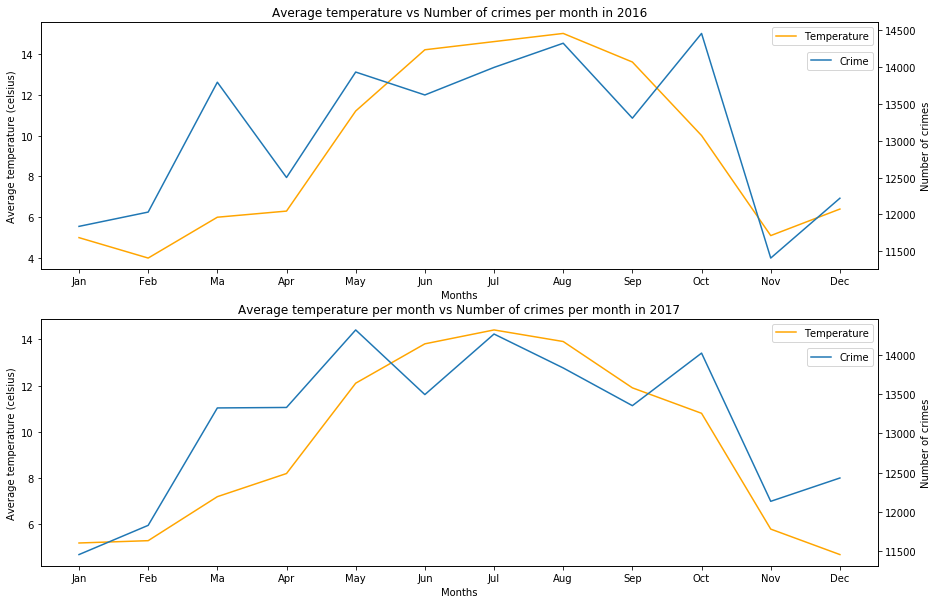

In [48]:
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
ax = sb.lineplot(np.arange(0, 12, step=1.0), mean_temp_4_years[mean_temp_4_years['Year'] == 2016].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2016].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)
ax.set_xlabel('Months')
ax.set_ylabel('Average temperature (celsius)')
ax2.set_ylabel('Number of crimes')

plt.title("Average temperature vs Number of crimes per month in 2016")
ax.legend(['Temperature'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.subplot(2,1,2)
ax = sb.lineplot(np.arange(0, 12, step=1.0), mean_temp_4_years[mean_temp_4_years['Year'] == 2017].drop('Year', axis=1).values.flatten().tolist(), color='orange')
ax2 = ax.twinx()

yvals2016 = psni_crime_data_grouped_month_year[psni_crime_data_grouped_month_year.Year == 2017].counts

ax2.set(xticks=(np.arange(0, 12, step=1.0)))
ax2.set_xticklabels(('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot((np.arange(0, 12, step=1.0)), yvals2016, ax=ax2)

ax.set_xlabel('Months')
ax.set_ylabel('Average temperature (celsius)')
ax2.set_ylabel('Number of crimes')

ax.legend(['Temperature'])
ax2.legend(['Crime'], bbox_to_anchor=(1,0.9), loc="upper right")

plt.title("Average temperature per month vs Number of crimes per month in 2017")

<b> 2016: There is a slight rise in temperature accompanying the rise in crime in march, although the sharp drop from march to april is a slight rise in temperature. The peak of crimes in October is not temperature's, which peaks in August - although august does have a high frequency of crime.

2017: The peak of crimes in May accompanies the rise of temperature - the trend of temperature rising in the early months of the year and rise in crimes does seem apparent.  The fall crime after October is joined by a the sharp decrease in temperature.

October still remains an issue - it is the peak of crimes and neither sunshine nor temperature peak at that month. 

Let's get a statistical figure for the correlation between monthly temperature and monthly crime. </b>

In [49]:
corr_temperature_4_years = pd.DataFrame(columns=['counts', 'temperature'])
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
crimes_month_year_4_years = psni_crime_data_grouped_month_year[(psni_crime_data_grouped_month_year['Year'] >= 2015)].reset_index()
for index,row in crimes_month_year_4_years.iterrows():
    counts = row['counts']
    month = months[row['Month']-1]
    temperature = mean_temp_4_years[mean_temp_4_years['Year'] == row['Year']].iloc[0][month]
    corr_temperature_4_years = corr_temperature_4_years.append({'counts': counts, 'temperature': temperature}, ignore_index=True)
corr_temperature_4_years.corr()

,counts,temperature
counts,1.000000,0.787959
temperature,0.787959,1.000000


<b> There is a strong positive correlation between month by month mean temperature and crime counts. Let's look at the correlation between mean monthly temperature and different crime types. It will be interesting to see whether ASB, which was identified as potentially season dependent, has strong correlation or not with temperature. </b>

In [50]:
psni_crime_data_grouped_crime_type.head()

,Month,Crime type,counts
0,1,Anti-social behaviour,8366
1,1,Bicycle theft,87
2,1,Burglary,1228
3,1,Criminal damage and arson,2781
4,1,Drugs,890


In [51]:
psni_crime_data_grouped_crime_type_month_year = psni_crime_data.groupby(['Year','Month','Crime type']).size().reset_index(name='counts')
psni_crime_data_grouped_crime_type_month_year['Temperature'] = None

months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
for index,row in psni_crime_data_grouped_crime_type_month_year.iterrows():
    month = months[row['Month']-1]
    temperature = mean_temp_4_years[mean_temp_4_years['Year'] == row['Year']].iloc[0][month]
    psni_crime_data_grouped_crime_type_month_year.at[index, 'Temperature'] = temperature

psni_crime_data_grouped_crime_type_month_year[['Temperature']] = psni_crime_data_grouped_crime_type_month_year[['Temperature']].apply(pd.to_numeric)
psni_crime_data_grouped_crime_type_month_year = psni_crime_data_grouped_crime_type_month_year.drop(['Year'], axis=1)

In [52]:
unique_crimes = psni_crime_data['Crime type'].unique()
correlation_crime_type = pd.DataFrame(columns=['Crime type', 'Correlation'])
for crime in unique_crimes:
    crime_type_counts = psni_crime_data_grouped_crime_type_month_year[psni_crime_data_grouped_crime_type_month_year['Crime type'] == crime]
    crime_type_counts = crime_type_counts.drop(['Crime type', 'Month'], axis=1)
    correlation = crime_type_counts.corr()
    correlation_crime_type = correlation_crime_type.append({'Crime type': crime, 'Correlation': correlation.iloc[0]['Temperature']}, ignore_index=True)
    
correlation_crime_type.nlargest(5, ['Correlation']).head()

,Crime type,Correlation
0,Anti-social behaviour,0.841309
1,Bicycle theft,0.707521
3,Criminal damage and arson,0.667986
12,Violence and sexual offences,0.566930
6,Possession of weapons,0.314003


In [53]:
correlation_crime_type.nsmallest(5, ['Correlation']).head()

,Crime type,Correlation
4,Drugs,-0.311053
2,Burglary,-0.098479
10,Theft from the person,-0.070984
13,Other crime,-0.018694
11,Vehicle crime,-0.002031


<b>Monthly Anti-social behaviour counts have the strongest positive correlation to mean monthly temprature. Drugs has the strongest negative correlation to monthly temperature. As observed before, drug crime was more prevelant in October, November and December so this could be the reason why. I will visualise anti-social behaviour counts to mean monthly temperature to verify a positive relationship:</b>

Text(0,0.5,'Number of crimes per month')

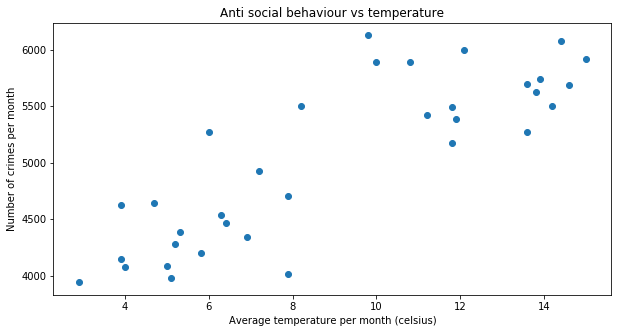

In [54]:
plt.figure(figsize=(10,5))
anti_social_crime = psni_crime_data_grouped_crime_type_month_year[psni_crime_data_grouped_crime_type_month_year['Crime type'] == 'Anti-social behaviour'].reset_index(drop=True)
plt.scatter(anti_social_crime.Temperature, anti_social_crime.counts)

psni_crime_data_grouped_crime_type = psni_crime_data_ranged.groupby(['Month', 'Crime type']).size().reset_index(name='counts')

# numpyArrayX = anti_social_crime.Temperature.values
# numpyArrayY = anti_social_crime.counts.values
# sb.regplot(anti_social_crime.counts,anti_social_crime.Temperature);
plt.title("Anti social behaviour vs temperature")
plt.xlabel('Average temperature per month (celsius)')
plt.ylabel('Number of crimes per month')

<b> There is a positive trend between ASB and temperature. Let's use a linear regression model to better visualise this. I'm going to use 2015-2018 which will give me 34 samples, which is limited for a regression model. The goal of the model is knowing the mean temperature for a month, can you predict what the anti social behaviour count will be for that month?</b> 

In [55]:
x = anti_social_crime[['Temperature']]
y = anti_social_crime['counts']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

20
20
14
14


In [56]:
regressor = LinearRegression()

In [57]:
result = regressor.fit(x_train, y_train)

In [58]:
y_pred = regressor.predict(x_test)

In [59]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def min_error(y_true, y_pred):
    maxdiff = 0
    for i, j in zip(y_true, y_pred):
        difference = i - j
        if (difference > maxdiff):
            maxdiff = difference
    return maxdiff

def max_error(y_true, y_pred):
    maxdiff = 0
    for i, j in zip(y_true, y_pred):
        difference = j - i
        if (difference > maxdiff):
            maxdiff = difference
    return maxdiff


print('Coefficients: \n', regressor.coef_)
print('Intercept: \n', regressor.intercept_)
print('Mean Absolute Percentage Error: %.2f' % mean_absolute_percentage_error(y_test, y_pred))
print('Mean Absolute Error: %.2f' % mean_absolute_error(y_test, y_pred))
print('Max Overforecasting Error: %.2f' % max_error(y_test, y_pred))
print('Max Underforecasting Error: %.2f' % min_error(y_test, y_pred))

Coefficients: 
 [ 160.40946196]
Intercept: 
 3549.36279509
Mean Absolute Percentage Error: 5.53
Mean Absolute Error: 292.16
Max Overforecasting Error: 384.45
Max Underforecasting Error: 1004.62


<b> On average a 5.5% percentage error and a mean absolute error of 292 crimes per month. This model does perform quite well with the test data. However, it has a big problem with underforecasting the number of ASB for particular months (>1000 difference) in which the temperature is not particularly high but the crime total is high. The peak in October could be the reason for this. </b>

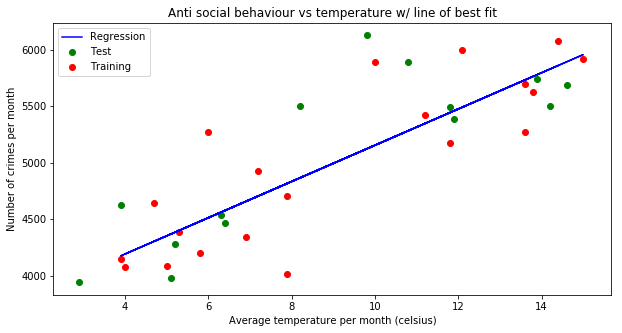

In [60]:
plt.figure(figsize=(10,5))
plt.scatter(x_test, y_test, color='green')
plt.scatter(x_train, y_train, color='red')
plt.plot(x_train, regressor.predict(x_train), color = 'blue')
plt.title("Anti social behaviour vs temperature w/ line of best fit")
plt.xlabel('Average temperature per month (celsius)')
plt.ylabel('Number of crimes per month')
plt.legend(['Regression', 'Test', 'Training'])
plt.show()

<b> I'm going to investigate the outlier with over 6000 crimes and around 10 celsius temperature </b>

In [61]:
anti_social_crime[anti_social_crime['counts'] > 6000]

,Month,Crime type,counts,Temperature
2,10,Anti-social behaviour,6126,9.8
23,7,Anti-social behaviour,6074,14.4


<b> October for ASB is an outlier and does not fit the model well. The peak of ASB in October could be because of Halloween celebrations. </b>

# ASB Location Crime Trends


<b> I want to investigate anti social behaviour further and see where it is happening using the provided data longitudinal and latitudinal data.</b>

In [62]:
anti_social_crime = psni_crime_data[(psni_crime_data['Crime type'] == 'Anti-social behaviour') & (psni_crime_data['Has_Location'] == True)].reset_index(drop=True)
anti_social_crime_sampled = anti_social_crime
anti_social_crime_sampled.head()

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter
0,0,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3
1,1,-5.891082,54.222501,bracken avenue,Anti-social behaviour,True,2015,8,31,3
2,2,-5.667276,54.663573,high street,Anti-social behaviour,True,2015,8,31,3
3,3,-5.962330,54.587243,rodney parade,Anti-social behaviour,True,2015,8,31,3
4,4,-5.894063,54.590423,brenda street,Anti-social behaviour,True,2015,8,31,3


In [63]:
# anti_social_crime_sampled.to_csv('anti_social_crime.csv', index=False)

<b> I did experiment with geocoding, however I felt I did not need to spend time getting properties like county and post code as none of my data I wanted to link used them as location properties. My investigation is below: </b>

In [64]:
osm = geocoder.osm([anti_social_crime.iloc[3].Latitude, anti_social_crime.iloc[3].Longitude], method='reverse')

In [65]:
result = osm.json

In [66]:
result

{'accuracy': 0.001,
 'address': 'Rodney Drive, Ballymurphy, Belfast, County Antrim, Northern Ireland, BT12 6HN, UK',
 'bbox': {'northeast': [54.5877489, -5.9623188],
  'southwest': [54.5872416, -5.9650519]},
 'city': 'Belfast',
 'confidence': 10,
 'country': 'UK',
 'country_code': 'gb',
 'county': 'County Antrim',
 'importance': 0.001,
 'lat': 54.5874972,
 'lng': -5.963674,
 'ok': True,
 'osm_id': '32932478',
 'osm_type': 'way',
 'place_id': '83608986',
 'place_rank': '26',
 'postal': 'BT12 6HN',
 'quality': 'residential',
 'raw': {'place_id': '83608986',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': '32932478',
  'boundingbox': ['54.5872416', '54.5877489', '-5.9650519', '-5.9623188'],
  'lat': '54.5874972',
  'lon': '-5.963674',
  'display_name': 'Rodney Drive, Ballymurphy, Belfast, County Antrim, Northern Ireland, BT12 6HN, UK',
  'place_rank': '26',
  'category': 'highway',
  'type': 'residential',
  'importan

In [67]:
osm = geocoder.bing([anti_social_crime.iloc[3].Latitude, anti_social_crime.iloc[3].Longitude], method='reverse', key='Aqi3VPnaoruTVcLa2v-o5gL_pwm7RnRDz0V6zzlGG3jgTUWT552Ud4gphnyOjIlH')

In [68]:
osm

<[OK] Bing - Reverse [29 Rodney Parade, Belfast, BT12 6]>

<b> I've ran a script that links the latitude and longitude of the crime to what crime neighbourhood it took place in using the police API - Crime Neighbhourhoods are part of an overall policing district and allow for Local Policing Teams (LPTs) and Neighbourhood Policing Teams (NPTs) to focus on crimes in the local area. This will allow me to categorise the crimes more meaningful and focus on a specific area in which ASB is prevelant.</b>

In [69]:
# anti_social_crime = pd.read_csv('anti_social_crime.csv')
# for index, row in anti_social_crime.iterrows():
#         longitude = row['Longitude']
#         latitude = row['Latitude']
#         url = f'https://data.police.uk/api/locate-neighbourhood?q={latitude},{longitude}'
#         response = requests.get(url)
#         neighbourhood = response.json()['neighbourhood']
#         anti_social_crime.at[index, 'Neighbourhood'] = neighbourhood
#         if (index % 1000 == 0):
#             print('Here')
#             anti_social_crime.to_csv('anti_social_crime.csv', index=False)

# anti_social_crime = pd.read_csv('anti_social_crime.csv')

anti_social_crime_sampled = pd.read_csv('anti_social_crime.csv')
anti_social_crime_sampled.head()

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter,Neighbourhood
0,0,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3,Strabane
1,1,-5.891082,54.222501,bracken avenue,Anti-social behaviour,True,2015,8,31,3,Downpatrick
2,2,-5.667276,54.663573,high street,Anti-social behaviour,True,2015,8,31,3,Newtownards
3,3,-5.962330,54.587243,rodney parade,Anti-social behaviour,True,2015,8,31,3,Woodbourne
4,4,-5.894063,54.590423,brenda street,Anti-social behaviour,True,2015,8,31,3,Strandtown


In [70]:
anti_social_crime_sampled.dtypes

index              int64
Longitude        float64
Latitude         float64
Location          object
Crime type        object
Has_Location        bool
Year               int64
Month              int64
Week               int64
Quarter            int64
Neighbourhood     object
dtype: object

In [71]:
anti_social_crime_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170910 entries, 0 to 170909
Data columns (total 11 columns):
index            170910 non-null int64
Longitude        170910 non-null float64
Latitude         170910 non-null float64
Location         147430 non-null object
Crime type       170910 non-null object
Has_Location     170910 non-null bool
Year             170910 non-null int64
Month            170910 non-null int64
Week             170910 non-null int64
Quarter          170910 non-null int64
Neighbourhood    170898 non-null object
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 13.2+ MB


<b> There are a few longitude and latitude inputs that did not provide a neighbhourhood upon the API call. I will drop these as they are minimal (0.007% of the dataset) </b>

In [72]:
anti_social_crime_sampled = anti_social_crime_sampled[~anti_social_crime_sampled['Neighbourhood'].isnull()]

<b> Neighbourhoods are part of policing districts. I manually mapped these using the information found in https://www.psni.police.uk/my-area/all-districts/ . This can provide a more high level overview of ASB crimes happening in the different districts, and allow for more mapping of, for example census data with administrative geographies. </b>

In [73]:
neighbourhood_district = {
    'Newtownabbey': 'Antrim and Newtownabbey',
    'Antrim': 'Antrim and Newtownabbey',
    'Newtownards': 'Ards and North Down',
    'Armagh': 'Armagh City, Banbridge and Craigavon',
    'Lurgan': 'Armagh City, Banbridge and Craigavon',
    'Lisburn Road': 'Belfast City',
    'Strandtown': 'Belfast City',
    'Tennent Street': 'Belfast City',
    'Woodbourne': 'Belfast City',
    'Coleraine': 'Causeway Coast and Glens',
    'Limavady': 'Causeway Coast and Glens',
    'Strabane': 'Derry City & Strabane',
    'Strand Road': 'Derry City & Strabane',
    'Enniskillen':'Fermanagh and Omagh',
    'Lisnaskea': 'Fermanagh and Omagh',
    'Omagh': 'Fermanagh and Omagh',
    'Lisburn':'Lisburn and Castlereagh',
    'Castlereagh': 'Lisburn and Castlereagh',
    'Ballymena': 'Mid and East Antrim',
    'Larne': 'Mid and East Antrim',
    'Dungannon': 'Mid Ulster',
    'Magherafelt': 'Mid Ulster',
    'Crossmaglen': 'Newry, Mourne and Down',
    'Downpatrick': 'Newry, Mourne and Down',
    'Newry': 'Newry, Mourne and Down',
    'Newtownhamilton': 'Newry, Mourne and Down'
}

def map_neighbourhood_district(row):
    neighbourhood = row['Neighbourhood']
    district = neighbourhood_district[neighbourhood]
    return district

In [74]:
anti_social_crime_sampled['Policing_District'] = anti_social_crime_sampled.apply(lambda row: map_neighbourhood_district (row),axis=1)

In [75]:
anti_social_crime_sampled.head()

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter,Neighbourhood,Policing_District
0,0,-7.378949,54.717334,dublin street,Anti-social behaviour,True,2015,8,31,3,Strabane,Derry City & Strabane
1,1,-5.891082,54.222501,bracken avenue,Anti-social behaviour,True,2015,8,31,3,Downpatrick,"Newry, Mourne and Down"
2,2,-5.667276,54.663573,high street,Anti-social behaviour,True,2015,8,31,3,Newtownards,Ards and North Down
3,3,-5.962330,54.587243,rodney parade,Anti-social behaviour,True,2015,8,31,3,Woodbourne,Belfast City
4,4,-5.894063,54.590423,brenda street,Anti-social behaviour,True,2015,8,31,3,Strandtown,Belfast City


<b> Using the Police API I was able to get the population for the policing neighbhourhoods </b>
<img src='population info.png' height='700' width='700'>

In [76]:
# # neighbourhood_population = pd.DataFrame(columns=['Neighbourhood', 'Population'])

# # for key in neighbourhood_district:
# #     url = f'https://data.police.uk/api/northern-ireland/{key}'
# #     response = requests.get(url)
# #     population = response.json()['population']
# #     neighbourhood_population = neighbourhood_population.append({'Neighbourhood': key, 'Population': population}, ignore_index=True)
neighbourhood_population = pd.read_csv('neighbourhood_population.csv')
# # neighbourhood_population.to_csv('neighbourhood_population.csv',index=False)

<b> I'm going to group the crimes by neighbhourhood to see where ASB is most prevelant by population </b>

In [77]:
grouped_asb_neighbourhood = anti_social_crime_sampled.groupby('Neighbourhood').size().reset_index(name='count')
# grouped_asb_neighbourhood

In [78]:
grouped_asb_neighbourhood = grouped_asb_neighbourhood.merge(neighbourhood_population, on='Neighbourhood')

def crime_per_population(row):
    population = row['Population']
    asb_count = row['count']
    return asb_count/population
grouped_asb_neighbourhood['ASB_per_population'] = grouped_asb_neighbourhood.apply(lambda row: crime_per_population(row), axis=1)

In [79]:
grouped_asb_neighbourhood.sort_values(by=['ASB_per_population'], ascending=False).head(30)

,Neighbourhood,count,Population,ASB_per_population
12,Lisburn Road,18191,33859,0.537257
24,Tennent Street,13905,55389,0.251043
25,Woodbourne,10378,53759,0.193047
22,Strand Road,11465,74386,0.154128
16,Newry,6128,46596,0.131513
23,Strandtown,9573,73175,0.130823
0,Antrim,4785,36860,0.129816
14,Lurgan,12308,95413,0.128997
4,Coleraine,8022,62423,0.128510
7,Dungannon,5817,46499,0.125099


<b> There's clearly an uneven distribution in ASB per population in different neighbhourhoods. Let's visualise this. </b>

Text(0,0.5,'Number of neighbourhoods')

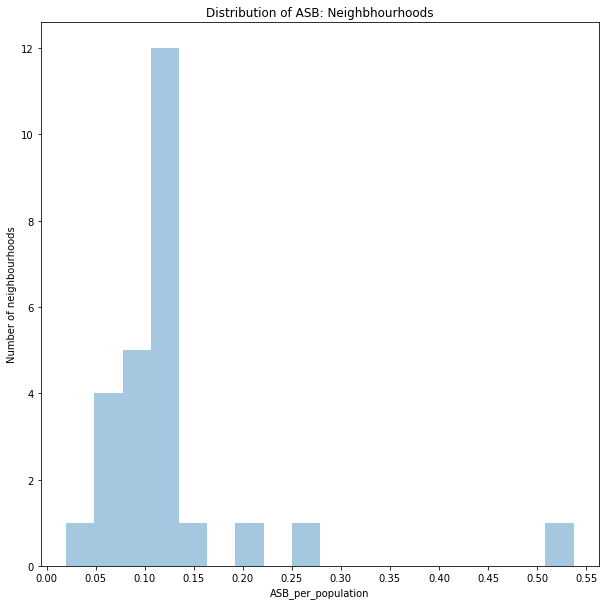

In [80]:
plt.figure(figsize=(10,10))
sb.distplot(grouped_asb_neighbourhood['ASB_per_population'], kde=False)
plt.title('Distribution of ASB: Neighbhourhoods')
plt.xticks(np.arange(0, 0.6, 0.05))
plt.ylabel('Number of neighbourhoods')

<b> Lisburn road neighbourhood is an outlier. There's a large concentration between 0.10 and 0.15 asb crimes per population. </b>

<b> The top four neighbourhoods are in the Belfast Policing District. There could be a link between population and ASB_per_population. </b>

In [81]:
grouped_asb_neighbourhood.corr()

,count,Population,ASB_per_population
count,1.000000,0.679060,0.794265
Population,0.679060,1.000000,0.139652
ASB_per_population,0.794265,0.139652,1.000000


<b> There is a positive correlation between the number of ASB crimes being committed and number of people living in a neighbourhood. Let's draw a scatter graph to visualise this.</b>

Text(0,0.5,'ASB Per Population')

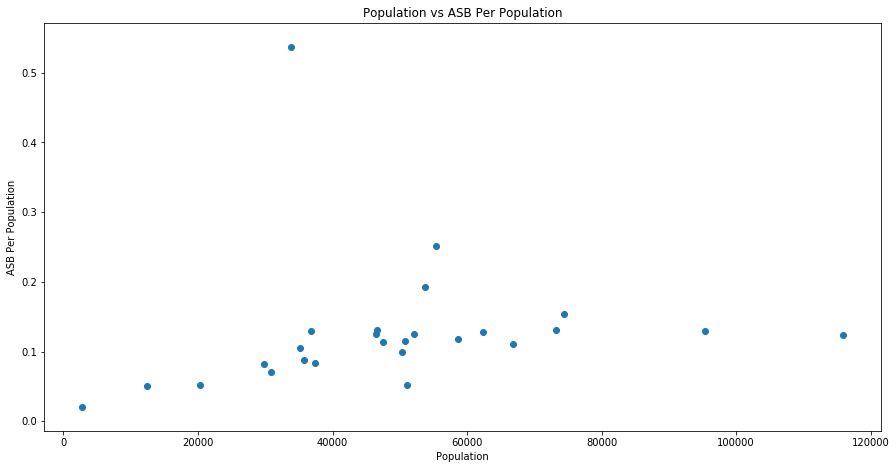

In [82]:
plt.figure(figsize=(15,7.5))
plt.scatter(grouped_asb_neighbourhood['Population'], grouped_asb_neighbourhood['ASB_per_population'])
plt.title('Population vs ASB Per Population')
plt.xlabel('Population')
plt.ylabel('ASB Per Population')

<b> There is a moderate positive trend. </b>

<b>I'm going to compare the compare the monthly distribution of ASB in Lisburn Road neighbhourhoods with the other neighbhourhoods 2016-2017. I want to see if the trend is different there, which is contributing to it being a outlier. </b>

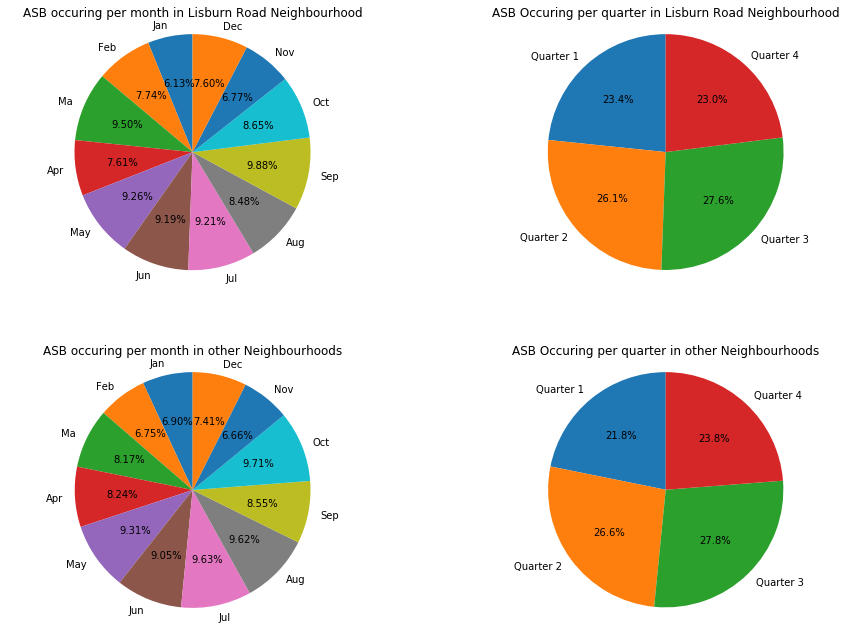

In [83]:
lisburn_road = anti_social_crime_sampled[anti_social_crime_sampled.Neighbourhood == 'Lisburn Road']
lisburn_road = lisburn_road[(lisburn_road['Year'] == 2016) | (lisburn_road['Year'] == 2017)].reset_index()
lisburn_road_month = lisburn_road.groupby(['Month']).size().reset_index(name='counts')
lisburn_road_quarter = lisburn_road.groupby(['Quarter']).size().reset_index(name='counts')


plt.figure(figsize=(15,11))

plt.subplot(2, 2, 1)
plt.pie(lisburn_road_month['counts'], labels = ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), \
        autopct='%1.2f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("ASB occuring per month in Lisburn Road Neighbourhood")

plt.subplot(2,2, 2)
plt.title("Chart of all crimes and anti-social behaviour occuring per quarter")
plt.pie(lisburn_road_quarter['counts'], labels = ('Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4'), autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("ASB Occuring per quarter in Lisburn Road Neighbourhood")

other_neighbhourhoods = anti_social_crime_sampled[anti_social_crime_sampled.Neighbourhood != 'Lisburn Road']
other_neighbhourhoods = other_neighbhourhoods[(other_neighbhourhoods['Year'] == 2016) | (other_neighbhourhoods['Year'] == 2017)].reset_index()
other_neighbhourhoods_months = other_neighbhourhoods.groupby(['Month']).size().reset_index(name='counts')
other_neighbhourhoods_quarters = other_neighbhourhoods.groupby(['Quarter']).size().reset_index(name='counts')

plt.subplot(2, 2, 3)
plt.pie(other_neighbhourhoods_months['counts'], labels = ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), \
        autopct='%1.2f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("ASB occuring per month in other Neighbourhoods")

plt.subplot(2,2, 4)
plt.title("Chart of all crimes and anti-social behaviour occuring per quarter")
plt.pie(other_neighbhourhoods_quarters['counts'], labels = ('Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4'), autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')
plt.title("ASB Occuring per quarter in other Neighbourhoods")

plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

<b> 
Lisburn Road: The highest number of ASB crimes occured in 2016-17 in September. The summer months (Quarter 3) have high rates of ASB but in March there is a notable rise.

Other Neighbhourhoods: The highest number of ASB crimes occured in 2016-17 in October. The summer months months (Quarter 3) have high rates of ASB. There is no notable rise like in Lisburn Road for March and September.</b>

<b> I'm going to take a look at March and September 2016 to find out where ASB on the Lisburn Road is happening in these peak months and if the pattern is different in least prevelant month of November. </b>

In [84]:
m = folium.Map(location=[54.5668, -5.95328], zoom_start=12)

lisburn_road_sampled = anti_social_crime_sampled[anti_social_crime_sampled.Neighbourhood == 'Lisburn Road']
lisburn_road_march_2016 = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2016) & (lisburn_road_sampled['Month'] == 3)].reset_index()

lisburn_road_november_2016 = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2016) & (lisburn_road_sampled['Month'] == 11)].reset_index()

lisburn_road_september_2016 = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2016) & (lisburn_road_sampled['Month'] == 9)].reset_index()

lisburn_road_september_2017 = lisburn_road_sampled[(lisburn_road_sampled['Year'] == 2017) & (lisburn_road_sampled['Month'] == 9)].reset_index()

asb_lisburn_road_coords_march_2016 = []
                            
for index, row in lisburn_road_march_2016.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    asb_lisburn_road_coords_march_2016.append(list(coords))

asb_lisburn_road_coords_november_2016 = []

for index, row in lisburn_road_november_2016.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    asb_lisburn_road_coords_november_2016.append(list(coords))
    
asb_lisburn_road_coords_september_2016 = []

for index, row in lisburn_road_september_2016.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    asb_lisburn_road_coords_september_2016.append(list(coords))
    
asb_lisburn_road_coords_september_2017 = []

for index, row in lisburn_road_september_2017.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    asb_lisburn_road_coords_september_2017.append(list(coords))

asb_lisburn_road_coords = []

asb_lisburn_road_coords.append(asb_lisburn_road_coords_march_2016)
asb_lisburn_road_coords.append(asb_lisburn_road_coords_september_2016)
asb_lisburn_road_coords.append(asb_lisburn_road_coords_november_2016)
asb_lisburn_road_coords.append(asb_lisburn_road_coords_september_2017)


HeatMapWithTime(asb_lisburn_road_coords, index=['March 2016', 'September 2016', 'November 2016', 'September 2017']).add_to(m)
#m.add_child(HeatMap(asb_lisburn_road_coords_november_2016, gradient={0: 'blue', 0: 'lime', .4: 'red'}))

m

<b> Holylands March 2016 </b>
<img src="holylands march 2016.PNG" width='700' height='700'>
<b> Holylands September 2016 </b>
<img src="holylands september 2016.PNG" width='700' height='700'>
<b> Holylands November 2016 </b>
<img src="holylands november 2016.PNG" width='700' height='700'>
<b> Holylands September 2017 </b>
<img src="holylands september 2017.PNG" width='700' height='700'>
<b> Holylands Hotspot in Google Maps </b>
<img src="holylands hotspot.PNG" width='700' height='700'>

<b>Longitude Latitude: 54.584584, -5.925854 </b>

<img src="radius holylands.png" width='700' height='700'>

<b> I've identified the Holylands as a hotspot for ASB in March and September. There's a considerable number of crime more in that area than any other area other than the city centre. Let's find crimes that are in a 0.5km radius of the centre of the hotspot. This could be because of St Patrick's Day in march and Fresher's Week in late September. </b>

In [85]:
crimes_within_distance = lisburn_road_sampled.copy()
crimes_within_distance = crimes_within_distance.iloc[0:0]
area_coord = ("54.584584", "-5.925854")
MAX_DISTANCE = 0.5

for index, row in lisburn_road_sampled.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    d = distance.vincenty(area_coord, coords)
    if (d.km <= MAX_DISTANCE):
        crimes_within_distance = crimes_within_distance.append(row)

In [86]:
crimes_within_distance.describe()

,index,Longitude,Latitude,Year,Month,Week,Quarter
count,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000,2888.000000
mean,2538.182133,-5.926044,54.584874,2016.504501,6.646468,27.163089,2.536011
std,1527.225280,0.002998,0.001621,0.925328,3.499322,15.253795,1.160225
min,2.000000,-5.933160,54.580268,2015.000000,1.000000,1.000000,1.000000
25%,1239.000000,-5.927597,54.583979,2016.000000,3.000000,13.000000,1.000000
50%,2449.000000,-5.925779,54.584756,2017.000000,7.000000,31.000000,3.000000
75%,3726.250000,-5.923939,54.586200,2017.000000,10.000000,39.000000,4.000000
max,6106.000000,-5.919741,54.588481,2018.000000,12.000000,53.000000,4.000000


<b> There's 2888 crimes in that hotspot. Let's get what percentage that is of the total crimes in the Lisburn Road Neighbhourhood </b>

In [87]:
lisburn_road_sampled.describe()

,index,Longitude,Latitude,Year,Month,Week,Quarter
count,18191.000000,18191.000000,18191.000000,18191.000000,18191.000000,18191.000000,18191.000000
mean,2540.318949,-5.934584,54.587189,2016.518608,6.545819,26.766643,2.503161
std,1532.023971,0.013077,0.011245,0.902305,3.421495,15.015986,1.117691
min,0.000000,-5.995609,54.539587,2015.000000,1.000000,1.000000,1.000000
25%,1244.000000,-5.936264,54.583035,2016.000000,4.000000,13.000000,2.000000
50%,2469.000000,-5.932404,54.587985,2017.000000,7.000000,26.000000,3.000000
75%,3750.000000,-5.927162,54.595941,2017.000000,9.000000,39.000000,3.000000
max,6120.000000,-5.910017,54.602452,2018.000000,12.000000,53.000000,4.000000


<b> 2888/181191 (16%) of ASB crimes in Lisburn Road happened in this 0.5km radius. I'm going to look at the distribution of these crimes in 2016 vs 2017 to see if there's any interesting observations I can draw from them. </b>

In [88]:
crimes_within_distance_grouped = crimes_within_distance.groupby(['Month', 'Year']).size().reset_index(name='counts')
crimes_within_distance_grouped[crimes_within_distance_grouped.Year == 2016].head(13)

,Month,Year,counts
0,1,2016,52
3,2,2016,71
6,3,2016,87
9,4,2016,72
12,5,2016,77
15,6,2016,76
17,7,2016,69
20,8,2016,44
23,9,2016,154
26,10,2016,116


Text(0.5,1,'Holylands: Anti social behaviour occurences 2016 vs 2017')

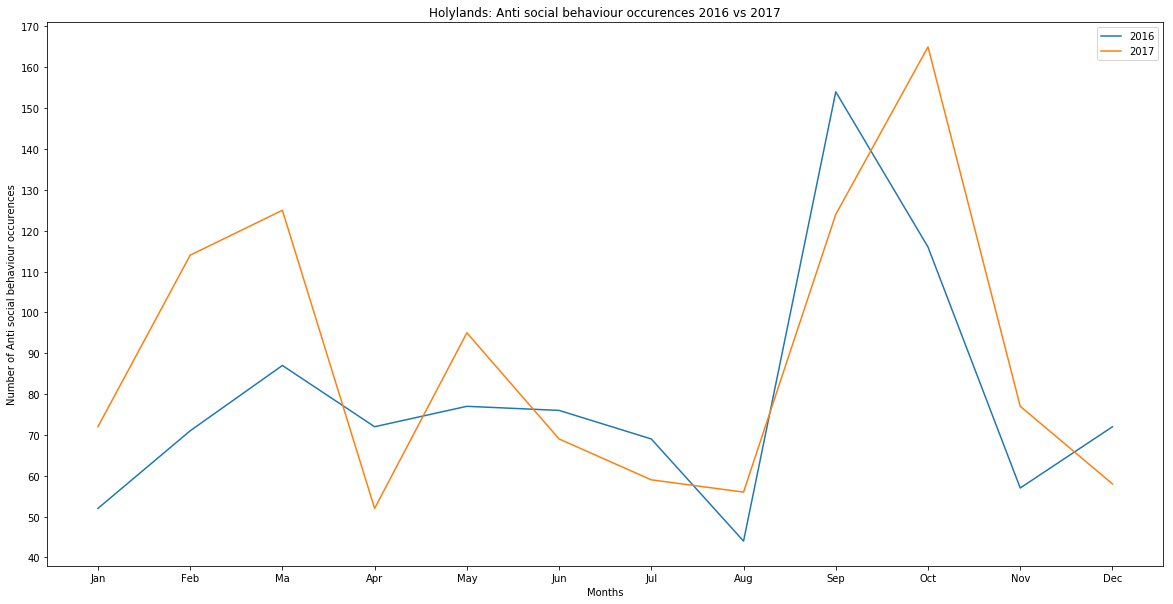

In [89]:
plt.figure(figsize=(20,10))
sb.lineplot(np.arange(0, 12, step=1.0), crimes_within_distance_grouped[crimes_within_distance_grouped.Year == 2016].counts)
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot(np.arange(0, 12, step=1.0), crimes_within_distance_grouped[crimes_within_distance_grouped.Year == 2017].counts)
plt.legend(['2016', '2017'])
plt.xlabel('Months')
plt.yticks(np.arange(40, 180, 10))
plt.ylabel('Number of Anti social behaviour occurences')
plt.title("Holylands: Anti social behaviour occurences 2016 vs 2017")

<b> 2016: September most ASB crimes, august the least. 2017: October most asb crimes, April the least. March sees a notable rise in both years, as well as September. The low ASB crimes in august isn't consistent with the general pattern, this could be due to students leaving for home.
    
I want to see if there's a different monthly frequency of crimes other than ASB happening in March vs August. Other crimes rising could influence the rise in ASB.</b>

In [90]:
crimes_within_distance = psni_crime_data_ranged.copy()
crimes_within_distance = crimes_within_distance.iloc[0:0]

area_coord = ("54.584584", "-5.925854")
MAX_DISTANCE = 0.5

not_asb_crimes = psni_crime_data_ranged[(psni_crime_data_ranged['Crime type'] != 'Anti-social behaviour') & (psni_crime_data_ranged['Has_Location'] == True)]
for index, row in not_asb_crimes.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    d = distance.vincenty(area_coord, coords)
    if (d.km <= MAX_DISTANCE):
        crimes_within_distance = crimes_within_distance.append(row)
        
crimes_within_distance.head()

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter
73170,4094,-5.932404,54.586753,botanic avenue,Bicycle theft,True,2016,1,53,1
73215,4139,-5.926404,54.583029,palestine street,Burglary,True,2016,1,53,1
73360,4284,-5.929958,54.586469,,Burglary,True,2016,1,53,1
73393,4317,-5.925399,54.585151,university avenue,Burglary,True,2016,1,53,1
73410,4334,-5.923238,54.585967,ormeau road,Burglary,True,2016,1,53,1


In [91]:
crimes_within_distance_grouped = crimes_within_distance.groupby(['Crime type', 'Month', 'Year']).size().reset_index(name='counts')

In [92]:
crimes_within_distance_grouped_march = crimes_within_distance_grouped[(crimes_within_distance_grouped['Month']  == 3)]
crimes_within_distance_grouped_march = crimes_within_distance_grouped_march.groupby(['Crime type']).counts.sum().reset_index(name='counts')
crimes_within_distance_grouped_march.head(30)

,Crime type,counts
0,Bicycle theft,6
1,Burglary,35
2,Criminal damage and arson,91
3,Drugs,19
4,Other crime,1
5,Other theft,41
6,Possession of weapons,4
7,Public order,2
8,Robbery,2
9,Shoplifting,7


In [93]:
crimes_within_distance_grouped_august = crimes_within_distance_grouped[(crimes_within_distance_grouped['Month']  == 8)]
crimes_within_distance_grouped_august = crimes_within_distance_grouped_august.groupby(['Crime type']).counts.sum().reset_index(name='counts')
crimes_within_distance_grouped_august.head(30)

,Crime type,counts
0,Bicycle theft,3
1,Burglary,25
2,Criminal damage and arson,40
3,Drugs,12
4,Other crime,1
5,Other theft,24
6,Possession of weapons,3
7,Robbery,3
8,Shoplifting,6
9,Theft from the person,1


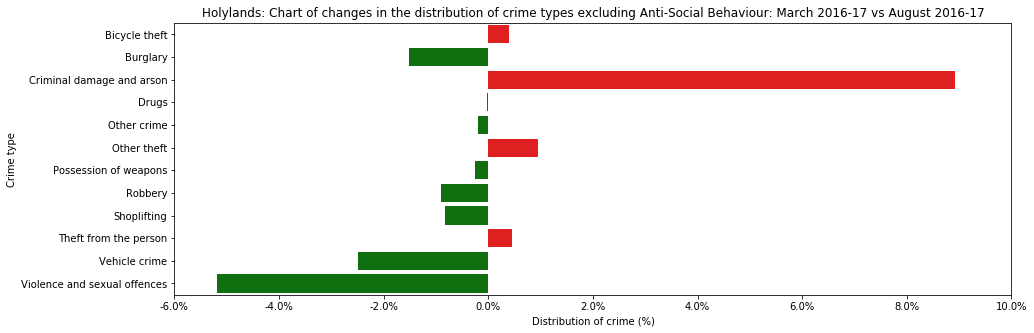

In [94]:
plt.figure(figsize=(15,5))

dictCrimeType = {}
total_august = crimes_within_distance_grouped_august['counts'].sum()
total_march = crimes_within_distance_grouped_march['counts'].sum()

for index, row in crimes_within_distance_grouped_august.iterrows():
    percent_august = row['counts']/float(total_august) * 100
    percent_march = crimes_within_distance_grouped_march[crimes_within_distance_grouped_march['Crime type'] == row['Crime type']].iloc[0]['counts']/float(total_march) * 100
    difference_percent = percent_march - percent_august
    dictCrimeType[row['Crime type']] = difference_percent
    
difference = pd.DataFrame.from_dict(dictCrimeType, orient='index')
difference.index = difference.index.astype(str)

# ax = sb.barplot(difference.index, difference[0])
ax = sb.barplot(difference[0], difference.index, palette=difference[0].apply(lambda x: 'r' if x>0 else 'g'))
ax.set_xlabel('Distribution of crime (%)')
ax.set_ylabel('Crime type')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlim(-6, 10)
plt.title("Holylands: Chart of changes in the distribution of crime types excluding Anti-Social Behaviour: March 2016-17 vs August 2016-17")

plt.show()

<b> Criminal damage and Arson is considerably up in March compared to August. Violence and sexual crimes is considerably down in March compared to August. This suggests a relationship between ASB and Criminal Damage and Arson. Let's look at a different hotspot and see if this holds. </b>

<b> City Centre March 2016 </b>
<img src="city centre march 2016.PNG" width='700' height='700'>
<b> City Centre November 2016 </b>
<img src="city centre november 2016.PNG" width='700' height='700'>
<b> City Centre Hotspot </b>
<img src="city centre hotspot.PNG" width='700' height='700'>

54.595016, -5.934491

In [95]:
crimes_within_city_centre_distance = lisburn_road_sampled.copy()
crimes_within_city_centre_distance = crimes_within_city_centre_distance.iloc[0:0]
area_coord = ("54.595016", "-5.934491")
MAX_DISTANCE = 0.5
for index, row in lisburn_road_sampled.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    d = distance.vincenty(area_coord, coords)
    if (d.km <= MAX_DISTANCE):
        crimes_within_city_centre_distance = crimes_within_city_centre_distance.append(row)

In [96]:
crimes_within_distance_city_centre_grouped = crimes_within_city_centre_distance.groupby(['Month', 'Year']).size().reset_index(name='counts')

Text(0.5,1,'City Centre: ASB 2016 vs 2017')

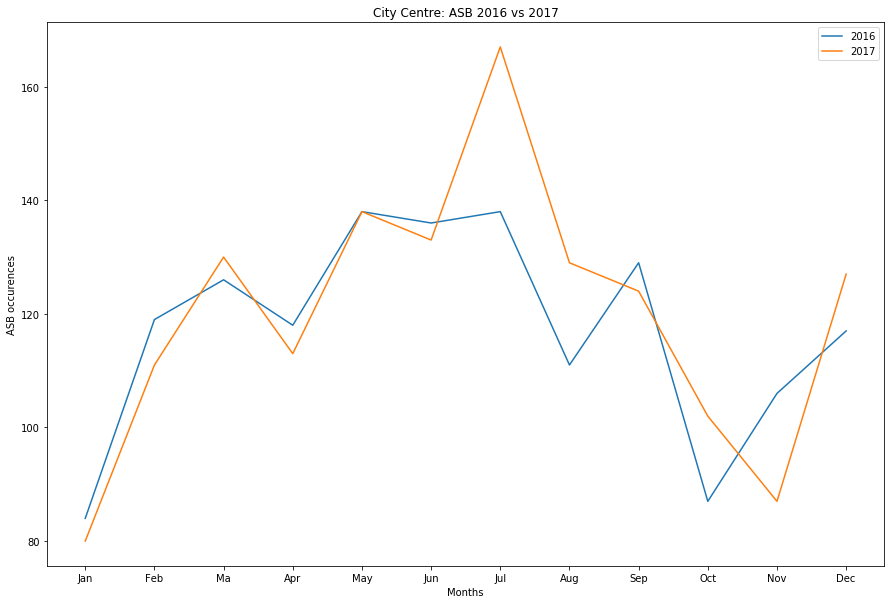

In [97]:
plt.figure(figsize=(15,10))
sb.lineplot(np.arange(0, 12, step=1.0), crimes_within_distance_city_centre_grouped[crimes_within_distance_city_centre_grouped.Year == 2016].counts)
plt.xticks(np.arange(0, 12, step=1.0), ('Jan', 'Feb', 'Ma', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))

sb.lineplot(np.arange(0, 12, step=1.0), crimes_within_distance_city_centre_grouped[crimes_within_distance_city_centre_grouped.Year == 2017].counts)
plt.legend(['2016', '2017'])
plt.xlabel('Months')
plt.ylabel('ASB occurences')
plt.title("City Centre: ASB 2016 vs 2017")

<b> 2016: Peak in summer months, low in January. Rise in January to February. 2017: Peak in July, low in January. Rise in December. Unlike the Holylands, August is not the lowest prevelance - January is. October is also not the peak. Let's take a look at the ditribution of other crimes in July and January. </b>

In [98]:
crimes_within_distance_city_centre = psni_crime_data_ranged.copy()
crimes_within_distance_city_centre = crimes_within_distance_city_centre.iloc[0:0]

area_coord = ("54.595016", "-5.934491")
MAX_DISTANCE = 0.5

not_asb_crimes = psni_crime_data_ranged[(psni_crime_data_ranged['Crime type'] != 'Anti-social behaviour') & (psni_crime_data_ranged['Has_Location'] == True)]
for index, row in not_asb_crimes.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    d = distance.vincenty(area_coord, coords)
    if (d.km <= MAX_DISTANCE):
        crimes_within_distance_city_centre = crimes_within_distance_city_centre.append(row)
        
crimes_within_distance_city_centre.head()

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter
73169,4093,-5.929880,54.595012,franklin street,Bicycle theft,True,2016,1,53,1
73171,4095,-5.930439,54.592551,bankmore street,Bicycle theft,True,2016,1,53,1
73172,4096,-5.930154,54.597254,donegall square north,Bicycle theft,True,2016,1,53,1
73179,4103,-5.932499,54.598004,college street,Bicycle theft,True,2016,1,53,1
73181,4105,-5.933066,54.591086,dublin road,Bicycle theft,True,2016,1,53,1


In [99]:
crimes_within_distance_city_centre_grouped = crimes_within_distance_city_centre.groupby(['Crime type', 'Month', 'Year']).size().reset_index(name='counts')
crimes_within_distance_grouped_january = crimes_within_distance_city_centre_grouped[(crimes_within_distance_city_centre_grouped['Month']  == 1)]
crimes_within_distance_grouped_january = crimes_within_distance_grouped_january.groupby(['Crime type']).counts.sum().reset_index(name='counts')
crimes_within_distance_grouped_january.head(30)

,Crime type,counts
0,Bicycle theft,12
1,Burglary,17
2,Criminal damage and arson,37
3,Drugs,27
4,Other crime,2
5,Other theft,45
6,Possession of weapons,4
7,Public order,2
8,Robbery,5
9,Shoplifting,38


In [100]:
crimes_within_distance_city_centre_grouped = crimes_within_distance_city_centre.groupby(['Crime type', 'Month', 'Year']).size().reset_index(name='counts')
crimes_within_distance_grouped_july = crimes_within_distance_city_centre_grouped[(crimes_within_distance_city_centre_grouped['Month']  == 7)]
crimes_within_distance_grouped_july = crimes_within_distance_grouped_july.groupby(['Crime type']).counts.sum().reset_index(name='counts')
crimes_within_distance_grouped_july.head(30)

,Crime type,counts
0,Bicycle theft,10
1,Burglary,18
2,Criminal damage and arson,45
3,Drugs,31
4,Other crime,4
5,Other theft,59
6,Possession of weapons,1
7,Public order,4
8,Robbery,3
9,Shoplifting,56


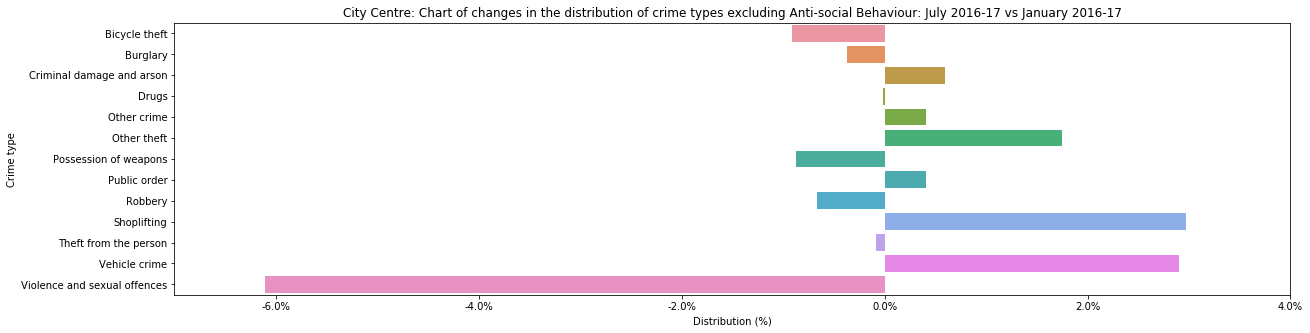

In [101]:
plt.figure(figsize=(20,5))

dictCrimeType = {}
total_january = crimes_within_distance_grouped_january['counts'].sum()
total_july = crimes_within_distance_grouped_july['counts'].sum()

for index, row in crimes_within_distance_grouped_january.iterrows():
    percent_january = row['counts']/float(total_january) * 100
    percent_july = crimes_within_distance_grouped_july[crimes_within_distance_grouped_july['Crime type'] == row['Crime type']].iloc[0]['counts']/float(total_july) * 100
    difference_percent = percent_july - percent_january
    dictCrimeType[row['Crime type']] = difference_percent
    
difference = pd.DataFrame.from_dict(dictCrimeType, orient='index')
difference.index = difference.index.astype(str)

ax = sb.barplot(difference[0], difference.index)
ax.set_ylabel('Crime type')
ax.set_xlabel('Distribution (%)')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlim(-7, 4)
plt.title("City Centre: Chart of changes in the distribution of crime types excluding Anti-social Behaviour: July 2016-17 vs January 2016-17")

plt.show()

<b> Like in the Holylands, Violence and sexual offences are down. However, Vehicle Crime and Shoplifting are up. This could be because the city centre being is a more affluent economic area than the Holylands. Shoplifting and other theft rising could be because there is more shops than the Holylands hotspot. Criminal damage and arson is up, although not as much as in the Holylands hotspot.</b> 

# Contribution to ASB: Perspectives

<b> I want to investigate what people living in the Lisburn Road neighbhourhood say are the biggest contributors to ASB in their local area to see if there is any link between other crimes occuring in the area and the findings previously are consistent with their perception of contributors. I'm going to load in the NICS dataset (https://www.justice-ni.gov.uk/articles/northern-ireland-crime-survey). </b> 

In [102]:
asb_perception_districts_2016_2017 = pd.read_csv('data/Perceptions of Crime Findings/perceptions_asb_district_2016_2017.csv')
asb_perception_districts_2016_2017.columns

Index(['Policing District', 'LE Abandoned or burnt-out cars',
       'BE Abandoned or burnt-out cars', 'HE Abandoned or burnt-out cars',
       'LE Noisy neighbours or loud parties',
       'BE Noisy neighbours or loud parties',
       'HE Noisy neighbours or loud parties',
       'LE People being drunk or rowdy in public places',
       'BE People being drunk or rowdy in public places',
       'HE People being drunk or rowdy in public places',
       'LE People using or dealing drugs', 'BE People using or dealing drugs',
       'HE People using or dealing drugs',
       'LE Teenagers hanging around on streets',
       'BE Teenagers hanging around on streets',
       'HE Teenagers hanging around on streets',
       'LE Rubbish or litter lying around',
       'BE Rubbish or litter lying around',
       'HE Rubbish or litter lying around',
       'LE Vandalism, graffiti and other deliberate damage to property',
       'BE Vandalism, graffiti and other deliberate damage to property',
    

<b> NICS use their own algorithm (awarding points for responses to types of crime) to calculate perceived high level of ASB. I will drop this to perform my own analysis. I will also drop the LE and HE as they are for the 95% confidence interval. This will not be needed as I only want the mean figure (BE) to see if there's an ASB problem specific to Belfast.  </b>

In [103]:
asb_perception_districts_2016_2017_focused = asb_perception_districts_2016_2017[['Policing District', 'BE Abandoned or burnt-out cars', 'BE Noisy neighbours or loud parties', 'BE People being drunk or rowdy in public places', 'BE People using or dealing drugs', 'BE Teenagers hanging around on streets', 'BE Rubbish or litter lying around',  'BE Vandalism, graffiti and other deliberate damage to property']].copy()
asb_perception_districts_2016_2017_focused.head(30)

,Policing District,BE Abandoned or burnt-out cars,BE Noisy neighbours or loud parties,BE People being drunk or rowdy in public places,BE People using or dealing drugs,BE Teenagers hanging around on streets,BE Rubbish or litter lying around,"BE Vandalism, graffiti and other deliberate damage to property"
0,Antrim and Newtownabbey,4.065041,8.130081,11.065574,24.017467,15.040650,17.886179,13.414634
1,Ards and North Down,0.000000,5.483871,15.806452,18.493151,10.645161,24.193548,9.032258
2,"Armagh City, Banbridge and Craigavon",2.356021,5.497382,13.350785,23.848238,13.350785,28.010471,11.518325
3,Belfast City,5.756579,10.708402,22.039474,36.619718,20.723684,33.059211,18.585526
4,Causeway Coast and Glens,1.048951,6.993007,16.783217,24.535316,10.139860,27.272727,10.139860
5,Derry City & Strabane,15.210356,11.326861,20.064725,24.221453,24.271845,23.948220,20.064725
6,Fermanagh and Omagh,4.602510,5.020921,10.878661,11.538462,7.949791,9.623431,5.439331
7,Lisburn and Castlereagh,1.709402,6.329114,7.203390,17.105263,12.236287,31.223629,13.502110
8,Mid and East Antrim,1.532567,3.831418,13.409962,27.343750,7.279693,29.118774,6.513410
9,Mid Ulster,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<b> Dropping Mid Ulster as the sample size was too small (n<100) for a percentage perception to be recorded. </b>

In [104]:
asb_perception_districts_2016_2017_focused = asb_perception_districts_2016_2017_focused[asb_perception_districts_2016_2017_focused['Policing District'] != 'Mid Ulster']

<b> Renaming columns to remove ('BE') from the start to make the visualisations more readable </b>

In [105]:
asb_perception_districts_2016_2017_focused = asb_perception_districts_2016_2017_focused.rename(columns=lambda x: re.sub('BE ','',x))

In [106]:
asb_perception_districts_2016_2017_focused.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 10
Data columns (total 8 columns):
Policing District                                              10 non-null object
Abandoned or burnt-out cars                                    10 non-null float64
Noisy neighbours or loud parties                               10 non-null float64
People being drunk or rowdy in public places                   10 non-null float64
People using or dealing drugs                                  10 non-null float64
Teenagers hanging around on streets                            10 non-null float64
Rubbish or litter lying around                                 10 non-null float64
Vandalism, graffiti and other deliberate damage to property    10 non-null float64
dtypes: float64(7), object(1)
memory usage: 720.0+ bytes


<b> The dataset has each policing district and percentage of people (sample size of each policing district > 100) living in those areas responding to each type of ASB as yes or no to it being a very/fairly big problem in their area. The values in the table are percentages of the sample size of that local area who responded yes. </b> 

<b> Let's visualise Belfast City's ASB perceptions as Lisburn Road neighbourhood is in Belfast City neighbhourhood. </b>

Text(0.5,1,'Belfast City: Perception of different types of anti-social behaviour as very / fairly big problems (%)')

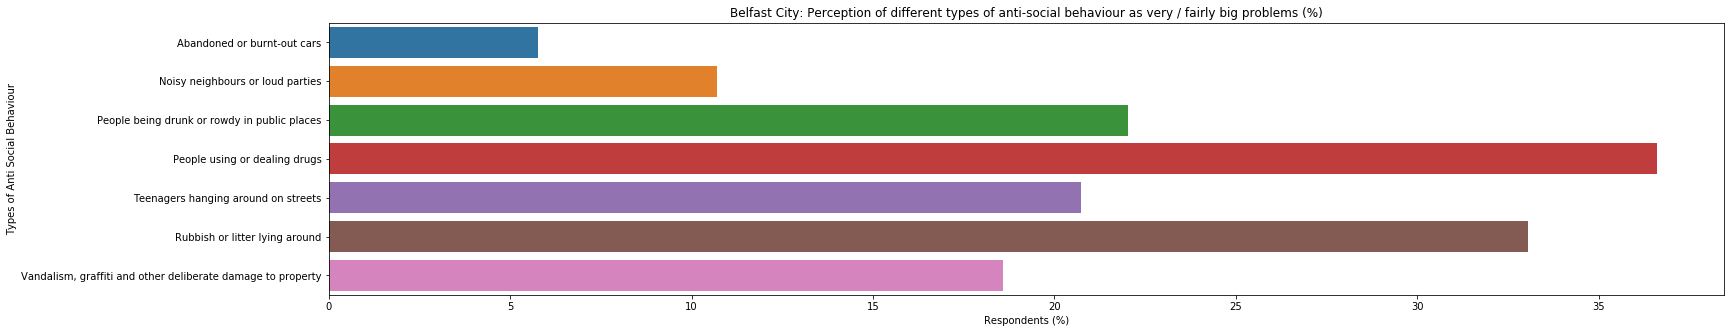

In [107]:
asb_perception_districts_2016_2017_focused.set_index(['Policing District'])
belfastcity_perception = asb_perception_districts_2016_2017_focused[asb_perception_districts_2016_2017_focused['Policing District'] == 'Belfast City']
x = belfastcity_perception.columns
y = belfastcity_perception.iloc[0].tolist()
plt.figure(figsize=(25, 5))
sb.barplot(y[1:], x[1:])
plt.ylabel('Types of Anti Social Behaviour')
plt.xlabel('Respondents (%)')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Belfast City: Perception of different types of anti-social behaviour as very / fairly big problems (%)')

<b> People using or dealing drugs and rubbish or litter lying around are the two perceived biggest ASB problems in Belfast City. Abandoned or burnt-out cars is viewed as the least significant ASB problem in Belfast City surveyed. Criminal damage which includes vandalism, graffiti and other deliberate damage to property (https://www.police.uk/crime-prevention-advice/criminal-damage-arson/) is 18.58%. Drug crime and criminal damage are both recorded separately from ASB, but minor crimes fitting their description could be recorded as anti social behaviour. Let's compare different types of ASB perceptions with the other districts, to compare crimes people in Belfast City view as being a very big problem and less so in other districts, and vice versa. </b>

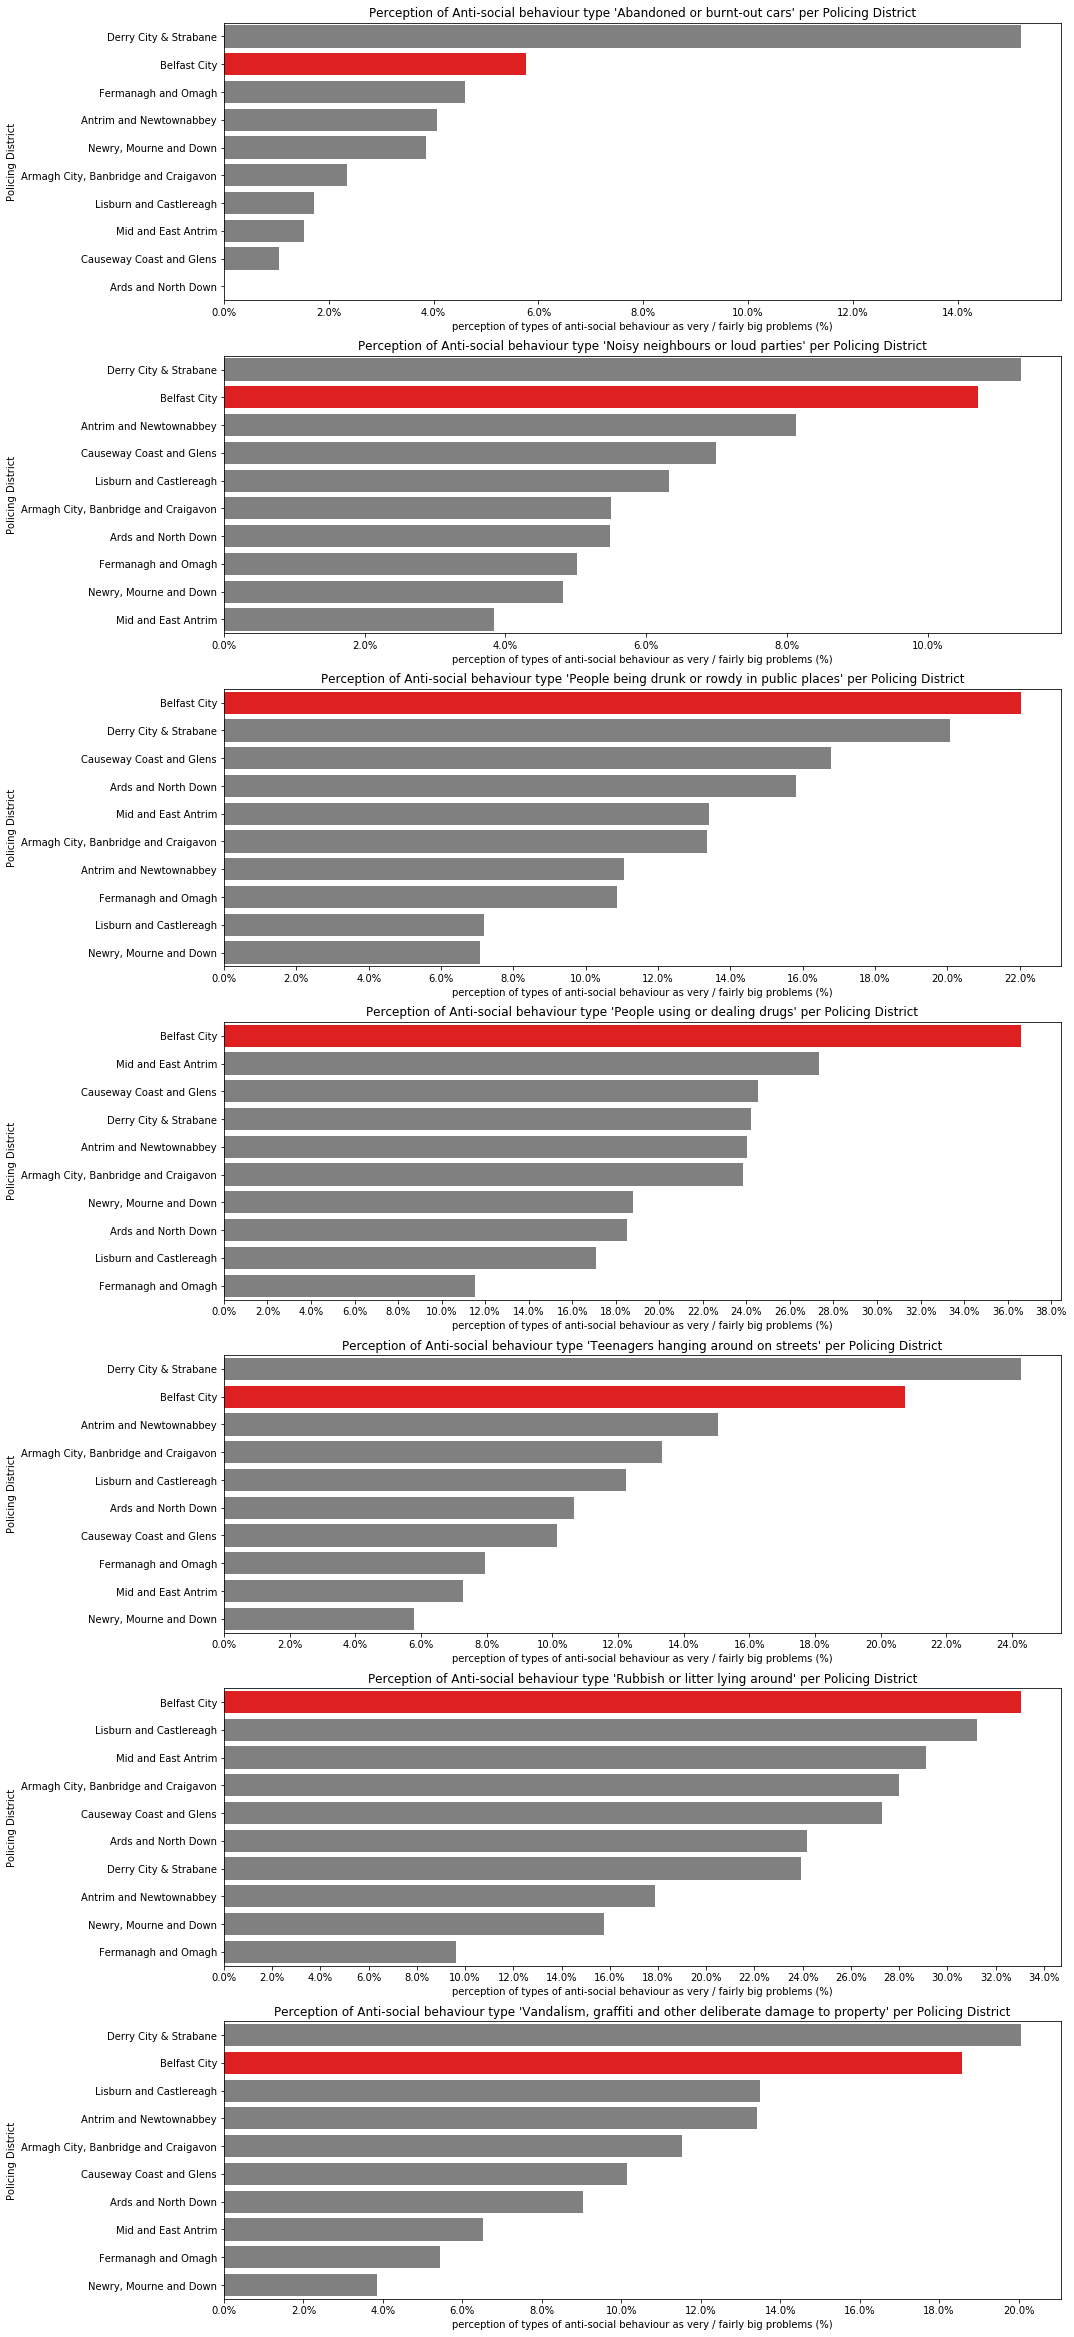

In [108]:
i = 1
plt.figure(figsize=(15,48))
for column in asb_perception_districts_2016_2017_focused.columns:
    if (column != 'Policing District'):
        ax = plt.subplot(len(asb_perception_districts_2016_2017_focused.columns),1,i)
        ax.set_xticks(np.arange(0, 45, step=2))
        plt.title(f"Perception of Anti-social behaviour type '{column}' per Policing District")
        asb_perception_districts_2016_2017_focused_sorted = asb_perception_districts_2016_2017_focused.sort_values([column], ascending=False)
        sb.barplot(asb_perception_districts_2016_2017_focused_sorted[column], asb_perception_districts_2016_2017_focused_sorted['Policing District'], orient='h', palette=asb_perception_districts_2016_2017_focused_sorted['Policing District'].apply(lambda x: 'r' if x == 'Belfast City' else 'grey'))
        plt.xlabel("perception of types of anti-social behaviour as very / fairly big problems (%)")
        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        i += 1

<b> People living in Belfast policing district perceive people using or dealing drugs as the biggest ASB problem in their area, the most of any policing district by approximately 10%. People being drunk or rowdy in public places and rubbish litter lying around is also perceived more by people living in Belfast City than in other districts. On a sidenote, people living in Derry City and Strabane perceive abandoned or burnt out cars as being an ASB problem in their local area disproportionately to other districts</b>

# Investigating the link between Parks/Open Spaces: Drug Crime and ASB 

<b> Drugs may play a role in perpetuating other types of anti-social behaviour. Illicit drug users may occupy public spaces or amenities in order to use drugs. I want to investigate whether or not there's a concentration of crimes around parks, in particular drug crime and ASB. I'm going to load in a dataset from Belfast City Council that lists all the parks in Belfast and their location.</b> 

In [109]:
parks_data = pd.read_csv('data/park/parksdata.csv')

In [110]:
parks_data.head(5)

,NAME,ADDRESS,POSTCODE,LONGITUDE,LATITUDE
0,Belfast City Hall,Donegall Square,BT1 5GS,-5.929895,54.596607
1,Gasworks,Ormeau Avenue,BT7 2JB,-5.922746,54.590815
2,Bridges Urban Skate Park,Corporation Street,BT1 3DE,-5.924104,54.604449
3,King William Park,Bradbury Place,BT7 1RS,-5.936026,54.587978
4,Dover Street Millennium Park,Shankill Road,BT13 2HQ,-5.942905,54.601582


<b> As I am concentrating on the Lisburn Road neighbhourhood for my analysis, I am going to include only parks that are within 0.5km of a crime in the lisburn road neighbhourhod </b>

In [111]:
# parks_within_crime_distance = parks_data.copy()
# parks_within_crime_distance = parks_within_crime_distance.iloc[0:0]
# MAX_DISTANCE = 0.5

# for park_index, park_row in parks_data.iterrows():
#     longitude = park_row['LONGITUDE']
#     latitude = park_row['LATITUDE']
#     area_coord = (latitude, longitude)
#     for index, row in lisburn_road_sampled.iterrows():
#         coords = (row['Latitude'], row['Longitude'])
#         d = distance.vincenty(area_coord, coords)
#         if (d.km <= MAX_DISTANCE):
#             print(park_row['NAME'])
#             parks_within_crime_distance = parks_within_crime_distance.append(park_row)
#             break;
            

In [112]:
# parks_within_crime_distance.to_csv('parks_within_crime_distance.csv', index=False)

In [113]:
parks_within_crime_distance = pd.read_csv('parks_within_crime_distance.csv')
parks_within_crime_distance.head(20)

,NAME,ADDRESS,POSTCODE,LONGITUDE,LATITUDE
0,Belfast City Hall,Donegall Square,BT1 5GS,-5.929895,54.596607
1,Gasworks,Ormeau Avenue,BT7 2JB,-5.922746,54.590815
2,Bridges Urban Skate Park,Corporation Street,BT1 3DE,-5.924104,54.604449
3,King William Park,Bradbury Place,BT7 1RS,-5.936026,54.587978
4,Ormeau Park,Ormeau Road,BT7 3GG,-5.916132,54.585517
5,Botanic Gardens,College Park Botanic Avenue,BT7 1LP,-5.932015,54.582249
6,Drumglass Park,Lisburn Road,BT9 6JF,-5.954841,54.574335
7,Lagan Meadows,Knightsbridge Park,BT9 5PB,-5.936648,54.561887
8,Grovelands,Stockman's Lane,BT9 7JB,-5.969532,54.569353
9,Musgrave Park,Stockman's Lane,BT9 7JB,-5.973881,54.569947


<b> Let's visualise the parks on a heat map with a high ASB count month (March 2016) to see if there's any concentration of ASB around parks </b>

In [114]:
m = folium.Map(location=[54.5668, -5.95328], zoom_start=12)

park_coords = []
crime_coords = []

for index, row in parks_within_crime_distance.iterrows():
    coords = (row['LATITUDE'], row['LONGITUDE'])
    park_coords.append(list(coords))
    
for index, row in lisburn_road_march_2016.iterrows():
    coords = (row['Latitude'], row['Longitude'])
    crime_coords.append(list(coords))

m.add_child(HeatMap(crime_coords))
for i, j in park_coords:
        folium.Circle([i,j], radius=300, fill_color='grey', fill_opacity=0.7, color='black').add_to(m)


m

<img src='parks mapped.png' width='700' height='700'>

<b> Drumglass Park and Botanic Gardens a clear concentration. Botanic Gardens includes the Holylands hotspot in its radius. City Hall does encompass a lot more of a dense crime hotspot. Due to the inaccuracy in locations setting the longtitude latitude to the nearest street, Belvoir Park Forest's crime radius may not include crimes happening within the forest. Overall, the shape of crime does not seem to concentrate itself close to parks in areas Stranmillis and Donegall Road. Let's get a count of the close crimes in the 0.3km radius of the parks to see if any park is a hotspot.  </b>

In [115]:
crimes = psni_crime_data_ranged[psni_crime_data_ranged['Has_Location'] == True]

In [116]:
# MAX_DISTANCE = 0.3

# for park_index, park_row in parks_within_crime_distance.iterrows():
#     count = 0
#     longitude = park_row['LONGITUDE']
#     latitude = park_row['LATITUDE']
#     area_coord = (latitude, longitude)
#     for index, row in crimes.iterrows():
#         coords = (row['Latitude'], row['Longitude'])
#         d = distance.vincenty(area_coord, coords)
#         if (d.km <= MAX_DISTANCE):
#             count += 1
#     parks_within_crime_distance.at[park_index, 'Close_Crimes_Count'] = count
           
parks_within_crime_distance = pd.read_csv('parks_within_crime_distance_count.csv')

In [117]:
parks_within_crime_distance.sort_values('Close_Crimes_Count', ascending=False)

,NAME,ADDRESS,POSTCODE,LONGITUDE,LATITUDE,Close_Crimes_Count
0,Belfast City Hall,Donegall Square,BT1 5GS,-5.929895,54.596607,4847.0
3,King William Park,Bradbury Place,BT7 1RS,-5.936026,54.587978,3330.0
2,Bridges Urban Skate Park,Corporation Street,BT1 3DE,-5.924104,54.604449,1156.0
5,Botanic Gardens,College Park Botanic Avenue,BT7 1LP,-5.932015,54.582249,465.0
1,Gasworks,Ormeau Avenue,BT7 2JB,-5.922746,54.590815,442.0
6,Drumglass Park,Lisburn Road,BT9 6JF,-5.954841,54.574335,294.0
8,Grovelands,Stockman's Lane,BT9 7JB,-5.969532,54.569353,186.0
4,Ormeau Park,Ormeau Road,BT7 3GG,-5.916132,54.585517,176.0
9,Musgrave Park,Stockman's Lane,BT9 7JB,-5.973881,54.569947,81.0
11,Wedderburn Park,Orpen Park,BT10 0BN,-5.987837,54.555355,31.0


<b>Lagan Meadows having 0 close crimes is because of its longitutde latitude radius being central in a forest area, as seen in the map above. Belfast City Hall has the highest crime count of any open space/park in Lisburn Road Neighbourhood. This could be because of its central location in the City Centre. King William Park also may have additional noise from being in a high footfall commercial area. I am going to drop these two parks from the table.</b>

In [118]:
park_coords = []
for index, row in parks_within_crime_distance[(parks_within_crime_distance['NAME'] != 'Belfast City Hall') & (parks_within_crime_distance['NAME'] != 'King William Park')].iterrows():
    coords = (row['LATITUDE'], row['LONGITUDE'])
    park_coords.append(list(coords))

In [119]:
park_coords

[[54.59081464670145, -5.9227463040104285],
 [54.60444946790272, -5.924104087169143],
 [54.5855165230949, -5.916131805645338],
 [54.582249006852685, -5.932014919679817],
 [54.574334885713384, -5.954841146640687],
 [54.561887223486956, -5.9366482628265365],
 [54.56935316416344, -5.96953219998335],
 [54.56994716540786, -5.973880524193518],
 [54.555185254529285, -5.950435654808607],
 [54.55535505750669, -5.9878366742481]]

<b> Let's find crimes that are within the 0.3km radius of a park to compare with the overall crime type distribution of the total dataset. </b>

In [120]:
# crimes_within_parks_distance =  psni_crime_data_ranged.copy()
# crimes_within_parks_distance = crimes_within_parks_distance.iloc[0:0]

# MAX_DISTANCE = 0.3

# for index, row in crimes.iterrows():
#     for i, j in park_coords:
#         coords = (row['Latitude'], row['Longitude'])
#         area_coords = (i, j)
#         d = distance.vincenty(area_coords, coords)
#         if (d.km <= MAX_DISTANCE):
#             crimes_within_parks_distance = crimes_within_parks_distance.append(row)
#             break;

# crimes_within_parks_distance.to_csv('crimes_park_distance.csv', index=False)
crimes_within_parks_distance = pd.read_csv('crimes_park_distance.csv')

In [121]:
crimes_within_parks_distance.head()

,index,Longitude,Latitude,Location,Crime type,Has_Location,Year,Month,Week,Quarter
0,14,-5.929275,54.582252,NaN,Anti-social behaviour,True,2016,1,53,1
1,131,-5.930676,54.583911,rugby road,Anti-social behaviour,True,2016,1,53,1
2,147,-5.927982,54.582122,NaN,Anti-social behaviour,True,2016,1,53,1
3,383,-5.955934,54.575958,marlborough court,Anti-social behaviour,True,2016,1,53,1
4,483,-5.921916,54.588541,cooke court,Anti-social behaviour,True,2016,1,53,1


In [122]:
crimes_within_parks_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 10 columns):
index           2760 non-null int64
Longitude       2760 non-null float64
Latitude        2760 non-null float64
Location        2341 non-null object
Crime type      2760 non-null object
Has_Location    2760 non-null bool
Year            2760 non-null int64
Month           2760 non-null int64
Week            2760 non-null int64
Quarter         2760 non-null int64
dtypes: bool(1), float64(2), int64(5), object(2)
memory usage: 196.8+ KB


<b> Let's group the crimes by crime type to compare the distribution of crime types. </b>

In [123]:
within_range_parks_crime_type = crimes_within_parks_distance.groupby(['Crime type']).size().reset_index(name='counts')
within_range_parks_crime_type.head()

,Crime type,counts
0,Anti-social behaviour,1094
1,Bicycle theft,79
2,Burglary,135
3,Criminal damage and arson,336
4,Drugs,124


<b> Let's find the crimes that are not 0.3km from Lisburn Road parks </b>

In [124]:
not_within_range_parks_crime_type = crimes[~crimes.isin(within_range_parks_crime_type)].groupby(['Crime type']).size().reset_index(name='counts')

In [125]:
not_within_range_parks_crime_type.head()

,Crime type,counts
0,Anti-social behaviour,122656
1,Bicycle theft,1605
2,Burglary,13893
3,Criminal damage and arson,37054
4,Drugs,11190


<b> Let's visualise the difference in crime type distribution between crimes within 0.3km of Lisburn Road parks and the rest of the PSNI dataset for 16-17 </b>

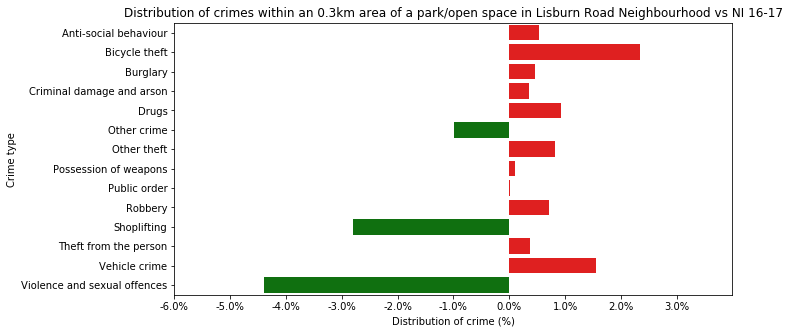

In [126]:
dictCrimeType = {}

total_within_range = within_range_parks_crime_type['counts'].sum()
total_all = not_within_range_parks_crime_type['counts'].sum()

plt.figure(figsize=(10,5))

for index, row in not_within_range_parks_crime_type.iterrows():
    percent_all = row['counts']/float(total_all) * 100
    percent_within_range = within_range_parks_crime_type[within_range_parks_crime_type['Crime type'] == row['Crime type']].iloc[0]['counts']/float(total_within_range) * 100
    difference_percent = percent_within_range - percent_all
    dictCrimeType[row['Crime type']] = difference_percent
    
difference = pd.DataFrame.from_dict(dictCrimeType, orient='index')
difference.index = difference.index.astype(str)

ax = sb.barplot(difference[0], difference.index, palette=difference[0].apply(lambda x: 'r' if x>0 else 'g'))
ax.set_ylabel('Crime type')
ax.set_xlabel('Distribution of crime (%)')
ax.set_xticks(np.arange(-6, 4, 1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Distribution of crimes within an 0.3km area of a park/open space in Lisburn Road Neighbourhood vs NI 16-17")
plt.xlim(-6, 4)

plt.show()

<b> There's approx 0.5% anti social behaviour crimes in in a 0.3km radius arounds parks in Lisburn Road neighbourhood than the rest of Northern Ireland. Violence and sexual offences sees the biggest decrease by approx. 4.5%, while bicycle theft is the largest increase. Drug crime however does increase by 1%, meaning there could be a relationship with open spaces. </b>